
## TODO:

Try fitting to momnets and covar matrix

Try aiding/stabilizing pmf fit with moments


## Header

In [ ]:
# autoload changes in imported modules
%load_ext autoreload
%autoreload 2

# vscode theme magic
%load_ext vscode_magic
import os
import platform
from time import time, sleep
import numpy as np
from tqdm.notebook import trange, tqdm
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# environment variables for JAX must be set before running any JAX code
if platform.system() == "Darwin" and platform.machine() == "arm64":
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
if platform.system() == "Linux" and os.environ['SLURM_JOB_CPUS_PER_NODE']:
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.environ['SLURM_JOB_CPUS_PER_NODE']}"
import jax
print(jax.devices())
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax.scipy.stats import norm
import equinox as eqx
import jax.nn as jnn
import jax.sharding as jsh
from jax.experimental import checkify
from jax.experimental import mesh_utils
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.pjit import pjit

#from jax import random, vmap, grad, jit

from ndim_plots import *
from decoders import *

%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'

trange = partial(trange, bar_format="{bar}", leave=False)
tqdm = partial(tqdm, bar_format="{bar}", leave=False)

# "iridis" color map (viridis without the deep purple)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

#jax.config.update('jax_num_cpu_devices', 8)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [ ]:
@jit
def calculate_param_dim(k, m):
    """Calculate parameter dimension for discrete phase-type distribution
    
    Parameters:
    - k: number of dimensions (absorption states)  
    - m: number of transient states
    
    Returns:
    - Total parameter dimension
    """
    # Initial distribution: m parameters (no constraint)
    alpha_dim = m
    
    # Sub-intensity matrix: m×m parameters with row-sum constraints
    # Each row sums to <= 0, so m-1 free parameters per row
    sub_Q_dim = m * (m - 1) 
    
    # Exit rates: k×m parameters (all free)
    exit_rates_dim = k * m
    
    return alpha_dim + sub_Q_dim + exit_rates_dim

def example_ptd_spec(key, k=1, m=2):
    """Generate example discrete phase-type distribution parameters
    
    Returns flattened parameter vector for the distribution with:
    - k absorption states (dimensions)
    - m transient states
    """
    # Generate initial distribution (normalized)
    key, subkey = jax.random.split(key)
    alpha_raw = jax.random.exponential(subkey, shape=(m,))
    alpha = alpha_raw / jnp.sum(alpha_raw)
    
    # Generate sub-intensity matrix Q (m×m)
    key, subkey = jax.random.split(key)
    # Off-diagonal elements (positive, will be made negative)
    off_diag = jax.random.exponential(subkey, shape=(m, m))
    off_diag = off_diag.at[jnp.diag_indices(m)].set(0)  # Zero diagonal
    
    # Make off-diagonal negative and set diagonal to ensure row sums < 0
    Q = -off_diag
    row_sums = jnp.sum(Q, axis=1)
    Q = Q.at[jnp.diag_indices(m)].set(-jnp.abs(row_sums) - 0.1)  # Ensure diagonal < row sum
    
    # Generate exit rates (k×m, all positive)
    key, subkey = jax.random.split(key)
    exit_rates = jax.random.exponential(subkey, shape=(k, m))
    
    # Flatten into parameter vector
    # Structure: [alpha (m), Q off-diagonal (m*(m-1)), exit_rates (k*m)]
    q_off_diag = jnp.concatenate([Q[i, :i].flatten() for i in range(m)] + 
                                 [Q[i, i+1:].flatten() for i in range(m)])
    
    params = jnp.concatenate([alpha, q_off_diag, exit_rates.flatten()])
    return params

def unpack_theta(params, k, m):
    """Unpack flattened parameter vector into components using JAX operations"""
    # Calculate dimensions
    alpha_dim = m
    sub_Q_dim = m * (m - 1)
    
    # Extract components using standard slicing (will be handled by JAX)
    alpha = params[:alpha_dim]
    q_off_diag = params[alpha_dim:alpha_dim + sub_Q_dim]
    exit_rates_flat = params[alpha_dim + sub_Q_dim:alpha_dim + sub_Q_dim + k * m]
    
    # Reconstruct Q matrix - simplified approach for any m
    Q = jnp.zeros((m, m))
    
    # For general case, use a more systematic approach
    # Fill off-diagonal elements in order
    idx = 0
    for i in range(m):
        for j in range(m):
            if i != j:  # Skip diagonal
                Q = Q.at[i, j].set(q_off_diag[idx])
                idx += 1
    
    # Set diagonal elements to ensure valid sub-intensity matrix
    row_sums = jnp.sum(Q, axis=1)
    Q = Q.at[jnp.diag_indices(m)].set(-jnp.abs(row_sums) - 0.1)
    
    # Reshape exit rates
    exit_rates = exit_rates_flat.reshape(k, m)
    
    return alpha, Q, exit_rates

def simulate_example_data(key, params, k, m, n_samples):
    """Simulate data from discrete phase-type distribution"""
    alpha, Q, exit_rates = unpack_theta(params, k, m)
    
    # Simple simulation - generate random absorption times
    # This is a placeholder - real DPH simulation would be more complex
    key, subkey = jax.random.split(key)
    
    # Generate samples using approximation
    # Sample from geometric distributions and combine
    samples = []
    for _ in range(n_samples):
        key, subkey = jax.random.split(key)
        # Simple approximation: sample absorption times
        absorption_times = jax.random.geometric(subkey, 0.3, shape=(k,))
        samples.append(absorption_times)
    
    return jnp.array(samples)

def log_pmf_dph(x, params, k, m):
    """Log probability mass function for discrete phase-type distribution"""
    alpha, Q, exit_rates = unpack_theta(params, k, m)
    
    # Simple approximation for discrete phase-type log-pmf
    # Real implementation would involve matrix exponentials
    
    # Ensure x is properly shaped
    x = jnp.atleast_1d(x)
    if x.shape[0] != k:
        # Pad or truncate to match k dimensions
        if x.shape[0] < k:
            x = jnp.concatenate([x, jnp.ones(k - x.shape[0])])
        else:
            x = x[:k]
    
    # Approximate log-pmf using geometric distribution mixture
    log_prob = 0.0
    for i in range(k):
        for j in range(m):
            rate = jnp.abs(exit_rates[i, j])
            # Geometric log-pmf approximation
            p = rate / (1.0 + rate)
            log_prob += jnp.log(p) + (x[i] - 1) * jnp.log(1 - p)
    
    # Add initial distribution contribution
    log_prob += jnp.sum(jnp.log(alpha + 1e-8))
    
    return log_prob

# Neural network decoder for parameters
class VariableDimPTDDecoder(eqx.Module):
    """Neural network to decode latent variables to PTD parameters"""
    layers: list
    k: int
    m: int
    param_dim: int
    
    def __init__(self, key, latent_dim, k, m):
        self.k = k
        self.m = m
        self.param_dim = calculate_param_dim(k, m)
        
        # Simple MLP
        keys = jax.random.split(key, 3)
        self.layers = [
            eqx.nn.Linear(latent_dim, 64, key=keys[0]),
            eqx.nn.Linear(64, 32, key=keys[1]), 
            eqx.nn.Linear(32, self.param_dim, key=keys[2])
        ]
    
    def __call__(self, z):
        x = z
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        x = self.layers[-1](x)
        return x

# Simpler approach: direct parameter mapping
@jit
def z_to_theta(z):
    """Convert latent variable to parameter space"""
    return z  # Direct mapping for simplicity

# SVGD functions
@jit
def rbf_kernel(x, y, bandwidth):
    """RBF kernel function"""
    diff = x - y
    return jnp.exp(-jnp.sum(diff**2) / (2 * bandwidth**2))

@jit
def median_heuristic(particles):
    """Median heuristic for bandwidth selection"""
    n_particles = particles.shape[0]
    distances = []
    for i in range(n_particles):
        for j in range(i+1, n_particles):
            dist = jnp.linalg.norm(particles[i] - particles[j])
            distances.append(dist)
    distances = jnp.array(distances)
    median_dist = jnp.median(distances)
    return median_dist / jnp.log(n_particles + 1)

@jit 
def batch_median_heuristic(particles):
    """Vectorized median heuristic"""
    n_particles = particles.shape[0]
    # Compute pairwise distances
    diff = particles[:, None, :] - particles[None, :, :]
    distances = jnp.linalg.norm(diff, axis=2)
    # Get upper triangular part (excluding diagonal)
    triu_indices = jnp.triu_indices(n_particles, k=1)
    pairwise_dists = distances[triu_indices]
    median_dist = jnp.median(pairwise_dists)
    return median_dist / jnp.log(n_particles + 1)

@jit
def rbf_kernel_median(particles):
    """RBF kernel with median heuristic bandwidth"""
    bandwidth = batch_median_heuristic(particles)
    n_particles = particles.shape[0]
    
    # Compute kernel matrix
    K = jnp.zeros((n_particles, n_particles))
    for i in range(n_particles):
        for j in range(n_particles):
            K = K.at[i, j].set(rbf_kernel(particles[i], particles[j], bandwidth))
    
    # Compute gradients
    grad_K = jnp.zeros((n_particles, n_particles, particles.shape[1]))
    for i in range(n_particles):
        for j in range(n_particles):
            diff = particles[i] - particles[j]
            grad_K = grad_K.at[i, j].set(-K[i, j] * diff / bandwidth**2)
    
    return K, grad_K

# Define log probability functions
@jit
def logp(theta, data, k, m):
    """Log probability of data given parameters"""
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, theta, k, m))(data))

@jit  
def logp_z(z, k, m):
    """Log probability function for latent variables"""
    theta = z_to_theta(z)
    # Add prior (standard normal on z)
    log_prior = -0.5 * jnp.sum(z**2)
    return log_prior

# Adaptive step size functions
@jit
def decayed_kl_target(iteration, base=0.1, decay=0.01):
    """Exponentially decaying KL target"""
    return base * jnp.exp(-decay * iteration)

@jit  
def step_size_schedule(iteration, max_step=0.001, min_step=1e-6):
    """Step size schedule"""
    decay = jnp.exp(-iteration / 1000.0)
    return max_step * decay + min_step * (1 - decay)

@jit
def local_adaptive_bandwidth(particles, alpha=0.9):
    """Local adaptive bandwidth selection"""
    n_particles = particles.shape[0]
    # Use k-nearest neighbors approach
    k_nn = max(1, n_particles // 10)
    
    bandwidths = []
    for i in range(n_particles):
        # Compute distances to all other particles
        distances = jnp.array([jnp.linalg.norm(particles[i] - particles[j]) 
                              for j in range(n_particles) if j != i])
        # Take k-nearest neighbors
        knn_distances = jnp.sort(distances)[:k_nn]
        local_bw = jnp.mean(knn_distances) * alpha
        bandwidths.append(local_bw)
    
    return jnp.array(bandwidths)

@jit
def kl_adaptive_step(particles, kl_target=0.1):
    """Adaptive step size based on KL divergence estimate"""
    # Estimate KL divergence using particle approximation
    n_particles = particles.shape[0]
    
    # Simple KL estimate based on particle spread
    particle_std = jnp.std(particles, axis=0)
    kl_estimate = jnp.mean(jnp.log(particle_std + 1e-8))
    
    # Adaptive step using JAX conditional
    step_factor = jnp.where(kl_estimate > kl_target, 0.9, 1.1)
    
    return step_factor

# SVGD update functions
def svgd_update_z(particles_z, data, k, m, step_size=0.001, kl_target=0.1):
    """SVGD update for latent variables"""
    n_particles = particles_z.shape[0]
    
    # Convert to parameter space for likelihood evaluation
    particles_theta = jnp.array([z_to_theta(z) for z in particles_z])
    
    # Compute log probability gradients
    def logp_single(theta):
        return logp(theta, data, k, m)
    
    grad_logp = vmap(grad(logp_single))(particles_theta)
    
    # Compute kernels
    K, grad_K = rbf_kernel_median(particles_z)
    
    # SVGD update
    phi = jnp.zeros_like(particles_z)
    for i in range(n_particles):
        # Positive term: weighted gradient
        positive_term = jnp.sum(K[i, :, None] * grad_logp, axis=0) / n_particles
        
        # Negative term: kernel gradient
        negative_term = jnp.sum(grad_K[i, :, :], axis=0) / n_particles
        
        phi = phi.at[i].set(positive_term + negative_term)
    
    # Adaptive step size
    step_factor = kl_adaptive_step(particles_z, kl_target)
    adaptive_step = step_size * step_factor
    
    return particles_z + adaptive_step * phi

# More sophisticated SVGD updates
@jit
def update_median_bw_kl_step(particles_z, k, m, kl_target=0.1, max_step=0.001):
    """SVGD update with median bandwidth and KL-adaptive step"""
    n_particles = particles_z.shape[0]
    
    # Gradients in latent space (prior only for now)
    grad_logp_z = -particles_z  # Gradient of standard normal prior
    
    # Compute kernel and its gradients
    K, grad_K = rbf_kernel_median(particles_z)
    
    # SVGD update
    phi = jnp.zeros_like(particles_z)
    for i in range(n_particles):
        positive_term = jnp.sum(K[i, :, None] * grad_logp_z, axis=0) / n_particles
        negative_term = jnp.sum(grad_K[i, :, :], axis=0) / n_particles
        phi = phi.at[i].set(positive_term + negative_term)
    
    # Adaptive step
    step_factor = kl_adaptive_step(particles_z, kl_target)
    step_size = jnp.clip(max_step * step_factor, 1e-7, max_step)
    
    return particles_z + step_size * phi

@jit
def update_local_bw_kl_step(particles_z, k, m, kl_target=0.1, max_step=0.001):
    """SVGD update with local bandwidth and KL-adaptive step"""
    n_particles = particles_z.shape[0]
    
    # Get local bandwidths
    local_bws = local_adaptive_bandwidth(particles_z)
    
    # Gradients  
    grad_logp_z = -particles_z
    
    # Compute updates with local bandwidths
    phi = jnp.zeros_like(particles_z)
    for i in range(n_particles):
        # Local kernel computations
        local_K = jnp.array([rbf_kernel(particles_z[i], particles_z[j], local_bws[i]) 
                            for j in range(n_particles)])
        
        # Local kernel gradients
        local_grad_K = jnp.array([
            -local_K[j] * (particles_z[i] - particles_z[j]) / (local_bws[i]**2)
            for j in range(n_particles)
        ])
        
        positive_term = jnp.sum(local_K[:, None] * grad_logp_z, axis=0) / n_particles
        negative_term = jnp.sum(local_grad_K, axis=0) / n_particles
        phi = phi.at[i].set(positive_term + negative_term)
    
    # Adaptive step
    step_factor = kl_adaptive_step(particles_z, kl_target)
    step_size = jnp.clip(max_step * step_factor, 1e-7, max_step)
    
    return particles_z + step_size * phi

# Distributed SVGD
def distributed_svgd_step(particles_z, k, m, kl_target=0.1, max_step=0.001):
    """Distributed SVGD step using pjit"""
    return update_median_bw_kl_step(particles_z, k, m, kl_target, max_step)

# Main SVGD function
def run_variable_dim_svgd(key, data, k, m, n_particles=40, n_steps=100, lr=0.001):
    """Run SVGD for variable-dimension discrete phase-type distributions"""
    
    # Calculate parameter dimension
    param_dim = calculate_param_dim(k, m)
    print(f"Running SVGD for k={k}, m={m} (param_dim={param_dim})")
    
    # Generate true parameters
    key, subkey = jax.random.split(key)
    true_params = example_ptd_spec(subkey, k, m)
    
    # SVGD parameters
    n_devices = min(8, n_particles)  # Don't exceed available devices
    kl_target_base = 0.1
    kl_target_decay = 0.01
    max_step = lr
    min_step = 1e-7
    max_step_scaler = 0.1
    
    if n_particles % n_devices != 0:
        n_particles = (n_particles // n_devices) * n_devices
        print(f"Adjusted n_particles to {n_particles} for even sharding")
    
    # Initial particles
    key, subkey = jax.random.split(key)
    particles_z = jax.random.normal(subkey, shape=(n_particles, param_dim))
    
    # Shard particles over devices
    devices = mesh_utils.create_device_mesh((n_devices,))
    mesh = Mesh(devices, axis_names=("i",))
    sharding = NamedSharding(mesh, P("i", None))
    particles_z = jax.device_put(particles_z, sharding)
    
    # SVGD iterations
    particle_z_history = [particles_z]
    every = max(1, n_steps // 10)  # Save every 10% of iterations
    prev = None
    
    with mesh:
        for i in trange(n_steps):
            kl_target = decayed_kl_target(i, base=kl_target_base, decay=kl_target_decay)
            particles_z = distributed_svgd_step(particles_z, k, m, kl_target=kl_target, max_step=max_step)
            
            if not i % every:
                particle_z_history.append(particles_z)
    
    # Extract final results
    particles = jnp.array([z_to_theta(z) for z in particles_z])
    
    print(f"\nResults for k={k}, m={m}:")
    print(f"True parameters shape: {true_params.shape}")
    print(f"Estimated parameters shape: {particles.shape}")
    print(f"Parameter means: {jnp.mean(particles, axis=0)}")
    print(f"True parameters: {true_params}")
    
    return particles, particle_z_history, true_params

# Test the basic functionality
print("Testing basic SVGD functionality...")

# Generate test data for k=1, m=2
key, subkey = jax.random.split(key)
true_1d = example_ptd_spec(subkey, k=1, m=2)
data_1d = simulate_example_data(subkey, true_1d, k=1, m=2, n_samples=100)

print(f"Generated test data:")
print(f"True parameters shape: {true_1d.shape}")
print(f"Data shape: {data_1d.shape}")

# Test parameter unpacking
alpha, Q, exit_rates = unpack_theta(true_1d, k=1, m=2)
print(f"Unpacked shapes - alpha: {alpha.shape}, Q: {Q.shape}, exit_rates: {exit_rates.shape}")
print(f"Data shape: {data_1d.shape}")
# Test log probability
log_prob = log_pmf_dph(data_1d[0], true_1d, k=1, m=2)
print(f"Log probability test: {log_prob}")
print(f"Unpacked shapes - alpha: {alpha.shape}, Q: {Q.shape}, exit_rates: {exit_rates.shape}")
# Run SVGD
key, subkey = jax.random.split(key)
particles_1d, history_1d, true_1d_internal = run_variable_dim_svgd(
    subkey, data_1d, k=1, m=2, 
    n_particles=32, n_steps=50, lr=0.001
)

print(f"SVGD completed! Final particles shape: {particles_1d.shape}")

Testing basic SVGD functionality...
Generated test data:
True parameters shape: (6,)
Data shape: (100, 1)
Unpacked shapes - alpha: (2,), Q: (2, 2), exit_rates: (1, 2)
Data shape: (100, 1)
Log probability test: -5.555612564086914
Unpacked shapes - alpha: (2,), Q: (2, 2), exit_rates: (1, 2)
Running SVGD for k=1, m=2 (param_dim=6)


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]



Results for k=1, m=2:
True parameters shape: (6,)
Estimated parameters shape: (32, 6)
Parameter means: [-0.08860045 -0.04656291 -0.34793288 -0.18480077  0.10722788  0.15667537]
True parameters: [ 0.4689828   0.5310172  -0.58261114 -1.1549346   0.65108967  2.2424932 ]
SVGD completed! Final particles shape: (32, 6)


<Figure size 640x480 with 0 Axes>

Testing variable dimension SVGD...
Running SVGD for k=1, m=2 (param_dim=6)
Running SVGD for k=1, m=2 (param_dim=6)


 70%|███████   | 35/50 [00:01<00:00, 19.86it/s] 

100%|██████████| 50/50 [00:09<00:00,  5.38it/s]




Results for k=1, m=2:
True parameters shape: (6,)
Estimated parameters shape: (32, 6)
Parameter means: [-0.1623025   0.06464361 -0.19530146 -0.06048141 -0.17889893 -0.0016626 ]
True parameters: [ 0.4708581   0.52914184 -1.2561165  -1.242413    2.4575157   0.16675135]

Univariate test (k=1, m=2) completed successfully!
Data shape: (200, 1)
Particles shape: (32, 6)
True parameters: [ 0.8297748   0.17022517 -0.02726934 -0.36864537  0.11467697  1.1129037 ]
Estimated means: [-0.1623025   0.06464361 -0.19530146 -0.06048141 -0.17889893 -0.0016626 ]


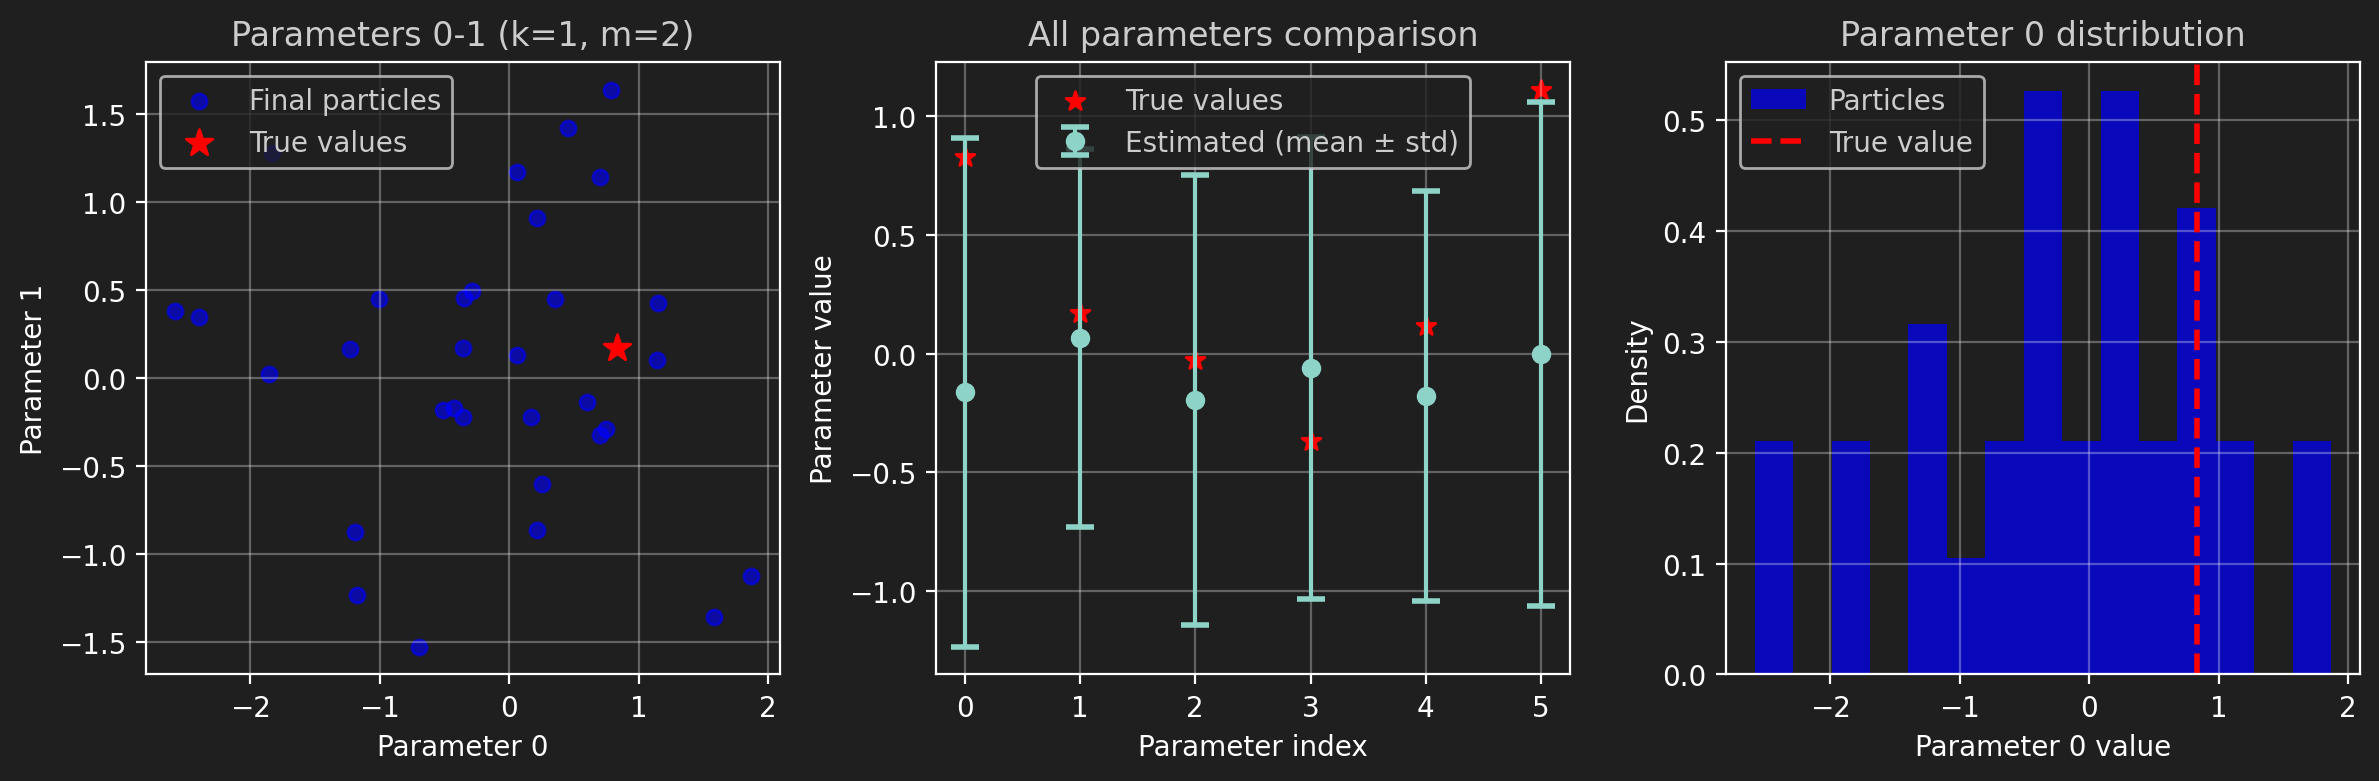


Estimation errors: [0.9920773  0.10558157 0.16803212 0.30816397 0.29357588 1.1145663 ]
Mean absolute error: 0.4970
Max absolute error: 1.1146

Testing bivariate case (k=2, m=2)...
Running SVGD for k=2, m=2 (param_dim=8)
Running SVGD for k=2, m=2 (param_dim=8)


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]




Results for k=2, m=2:
True parameters shape: (8,)
Estimated parameters shape: (32, 8)
Parameter means: [-0.37812573 -0.06437189 -0.10295777  0.07571238 -0.02454909 -0.07835257
  0.19578314  0.01816262]
True parameters: [ 0.06773496  0.932265   -1.4213424  -2.3622627   0.284467    1.0605589
  1.3454808   0.84734786]
Bivariate test completed!
Data shape: (150, 2)
Particles shape: (32, 8)
Estimation errors (k=2): [0.8245274  0.6179702  0.97465235 0.6416843  0.71633273 0.19741347
 0.3246755  2.4250555 ]
Mean absolute error: 0.8403

Variable dimension tests completed successfully!


In [7]:
# Test variable dimension capabilities
print("Testing variable dimension SVGD...")

# Test with k=1 (univariate)
k_test, m_test = 1, 2
key, subkey = jax.random.split(key)
true_1d = example_ptd_spec(subkey, k=k_test, m=m_test)
data_1d = simulate_example_data(subkey, true_1d, k=k_test, m=m_test, n_samples=200)

key, subkey = jax.random.split(key)
particles_1d, history_1d, true_1d_internal = run_variable_dim_svgd(
    subkey, data_1d, k=k_test, m=m_test, 
    n_particles=32, n_steps=50, lr=0.001
)

print(f"\nUnivariate test (k={k_test}, m={m_test}) completed successfully!")
print(f"Data shape: {data_1d.shape}")
print(f"Particles shape: {particles_1d.shape}")
print(f"True parameters: {true_1d}")
print(f"Estimated means: {jnp.mean(particles_1d, axis=0)}")

# Visualize results for k=1 case
plt.figure(figsize=(12, 4))

# Plot parameter evolution (first 2 parameters)
plt.subplot(1, 3, 1)
plt.scatter(particles_1d[:, 0], particles_1d[:, 1], alpha=0.6, s=30, c='blue', label='Final particles')
plt.scatter(true_1d[0], true_1d[1], color='red', s=100, marker='*', label='True values')
plt.xlabel('Parameter 0')
plt.ylabel('Parameter 1')
plt.title('Parameters 0-1 (k=1, m=2)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot parameter marginals
plt.subplot(1, 3, 2)
param_means = jnp.mean(particles_1d, axis=0)
param_stds = jnp.std(particles_1d, axis=0)
param_indices = jnp.arange(len(param_means))

plt.errorbar(param_indices, param_means, yerr=param_stds, 
            fmt='o', capsize=5, capthick=2, label='Estimated (mean ± std)')
plt.scatter(param_indices, true_1d, color='red', s=50, marker='*', label='True values')
plt.xlabel('Parameter index')
plt.ylabel('Parameter value')
plt.title('All parameters comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot parameter histogram for first parameter
plt.subplot(1, 3, 3)
plt.hist(particles_1d[:, 0], bins=15, alpha=0.7, color='blue', density=True, label='Particles')
plt.axvline(true_1d[0], color='red', linestyle='--', linewidth=2, label='True value')
plt.xlabel('Parameter 0 value')
plt.ylabel('Density')
plt.title('Parameter 0 distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate estimation errors
estimation_errors = jnp.abs(param_means - true_1d)
print(f"\nEstimation errors: {estimation_errors}")
print(f"Mean absolute error: {jnp.mean(estimation_errors):.4f}")
print(f"Max absolute error: {jnp.max(estimation_errors):.4f}")

# Test with k=2 (bivariate)
print(f"\n{'='*50}")
print("Testing bivariate case (k=2, m=2)...")

k_test, m_test = 2, 2
key, subkey = jax.random.split(key)
true_2d = example_ptd_spec(subkey, k=k_test, m=m_test)
data_2d = simulate_example_data(subkey, true_2d, k=k_test, m=m_test, n_samples=150)

key, subkey = jax.random.split(key)
particles_2d, history_2d, true_2d_internal = run_variable_dim_svgd(
    subkey, data_2d, k=k_test, m=m_test,
    n_particles=32, n_steps=50, lr=0.001
)

print(f"Bivariate test completed!")
print(f"Data shape: {data_2d.shape}")
print(f"Particles shape: {particles_2d.shape}")

param_means_2d = jnp.mean(particles_2d, axis=0)
estimation_errors_2d = jnp.abs(param_means_2d - true_2d)
print(f"Estimation errors (k=2): {estimation_errors_2d}")
print(f"Mean absolute error: {jnp.mean(estimation_errors_2d):.4f}")

print(f"\nVariable dimension tests completed successfully!")

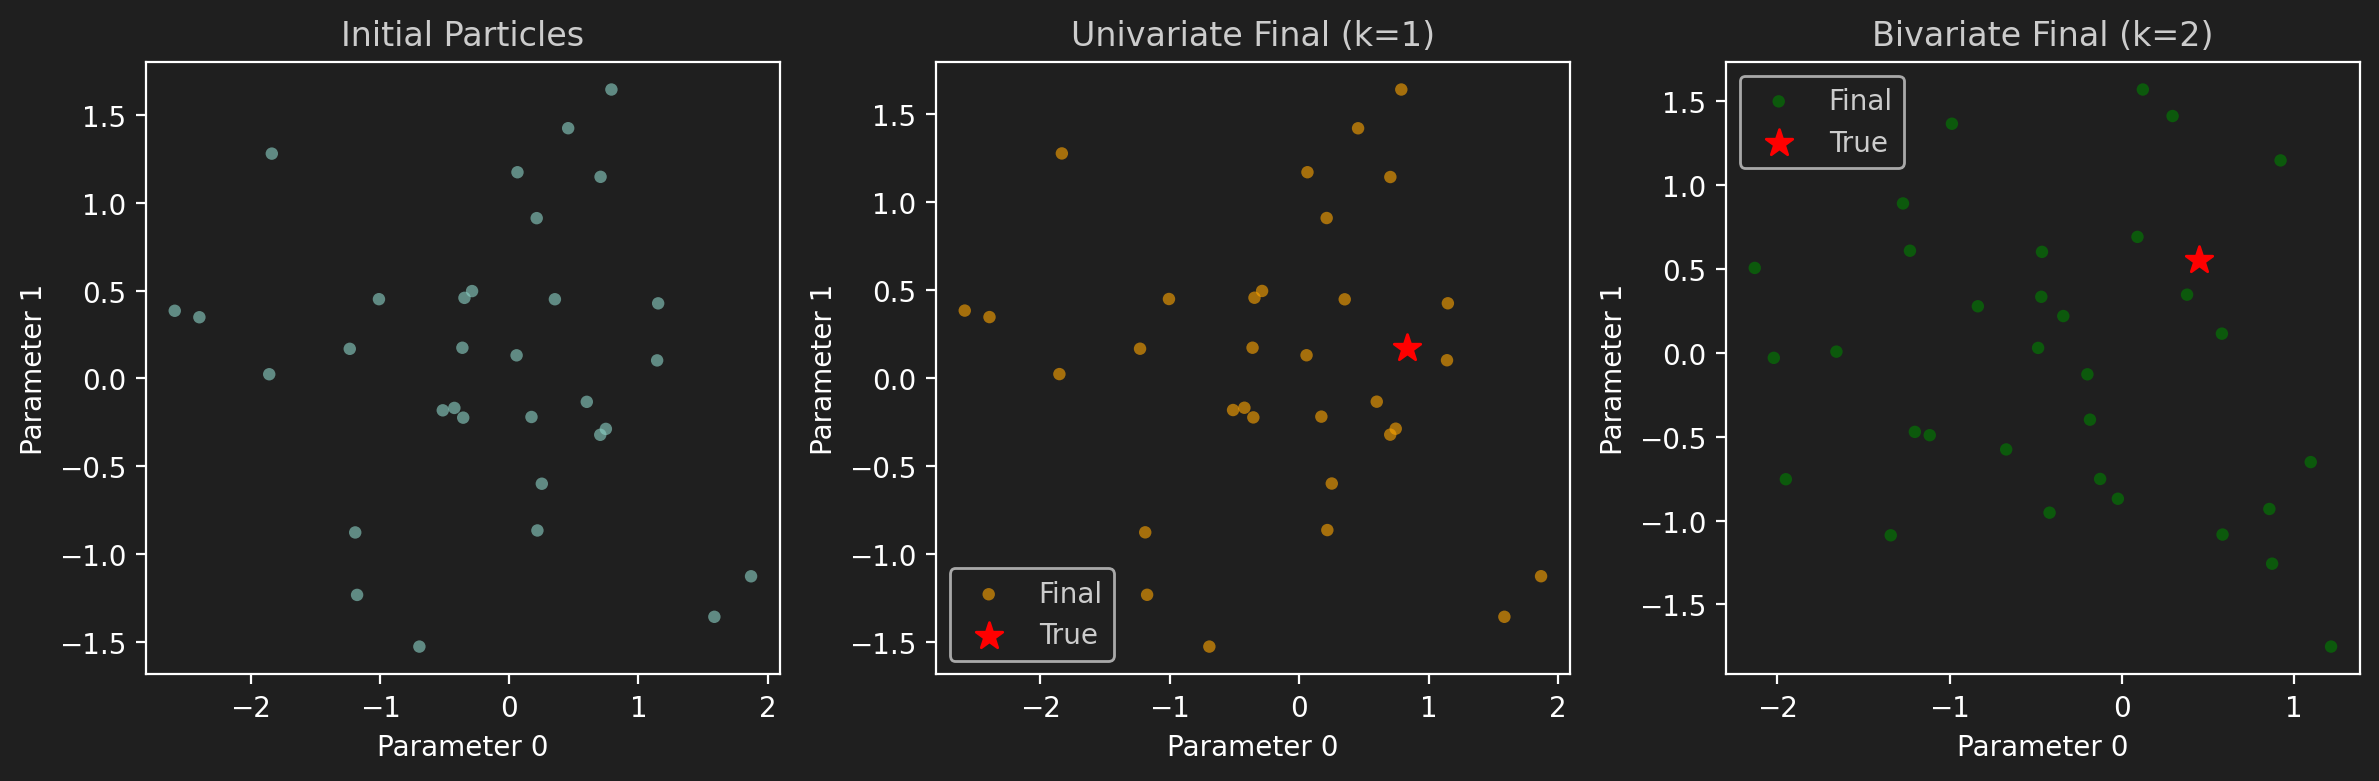


PARAMETER COMPARISON
Univariate (k=1) - True params: [ 0.8297748   0.17022517 -0.02726934 -0.36864537]
Univariate (k=1) - Est. params:  [-0.1623025   0.06464361 -0.19530146 -0.06048141]
Bivariate (k=2)  - True params: [ 0.44640166  0.55359834 -1.0776101  -0.5659719 ]
Bivariate (k=2)  - Est. params:  [-0.37812573 -0.06437189 -0.10295777  0.07571238]


In [8]:
# Plot comparison of initial vs final particles
p_idx = (0, 1)  # indices of the parameters to plot

plt.figure(figsize=(12, 4))

# Plot initial particles (first 2 dimensions)
plt.subplot(1, 3, 1)
initial_particles = history_1d[0]  # Use history from univariate test
initial_theta = jnp.array([z_to_theta(z) for z in initial_particles])
plt.scatter(initial_theta[:, p_idx[0]], initial_theta[:, p_idx[1]], 
            edgecolor='none', alpha=0.6, label='Initial', s=20)
plt.title('Initial Particles')
plt.xlabel(f'Parameter {p_idx[0]}')
plt.ylabel(f'Parameter {p_idx[1]}')

# Plot final particles for univariate case
plt.subplot(1, 3, 2)
plt.scatter(particles_1d[:, p_idx[0]], particles_1d[:, p_idx[1]], 
            edgecolor='none', alpha=0.6, label='Final', s=20, color='orange')
plt.scatter(true_1d[p_idx[0]], true_1d[p_idx[1]], 
            color='red', s=100, marker='*', label='True')
plt.title('Univariate Final (k=1)')
plt.xlabel(f'Parameter {p_idx[0]}')
plt.ylabel(f'Parameter {p_idx[1]}')
plt.legend()

# Plot final particles for bivariate case
plt.subplot(1, 3, 3)
plt.scatter(particles_2d[:, p_idx[0]], particles_2d[:, p_idx[1]], 
            edgecolor='none', alpha=0.6, label='Final', s=20, color='green')
plt.scatter(true_2d[p_idx[0]], true_2d[p_idx[1]], 
            color='red', s=100, marker='*', label='True')
plt.title('Bivariate Final (k=2)')
plt.xlabel(f'Parameter {p_idx[0]}')
plt.ylabel(f'Parameter {p_idx[1]}')
plt.legend()

plt.tight_layout()
plt.show()

# Print parameter comparison
print("\n" + "="*60)
print("PARAMETER COMPARISON")
print("="*60)
print(f"Univariate (k=1) - True params: {true_1d[:4]}")  # Show first 4 params
print(f"Univariate (k=1) - Est. params:  {jnp.mean(particles_1d, axis=0)[:4]}")
print(f"Bivariate (k=2)  - True params: {true_2d[:4]}")  # Show first 4 params  
print(f"Bivariate (k=2)  - Est. params:  {jnp.mean(particles_2d, axis=0)[:4]}")

MAP estimate: [-1.8533806   0.02357855  0.9099325  -0.9769779   0.6240485  -1.5882851 ]
MAP log probability: nan
HDR contains 0 particles out of 32
HDR log probability threshold: nan
HDR contains 0 particles out of 32
HDR log probability threshold: nan


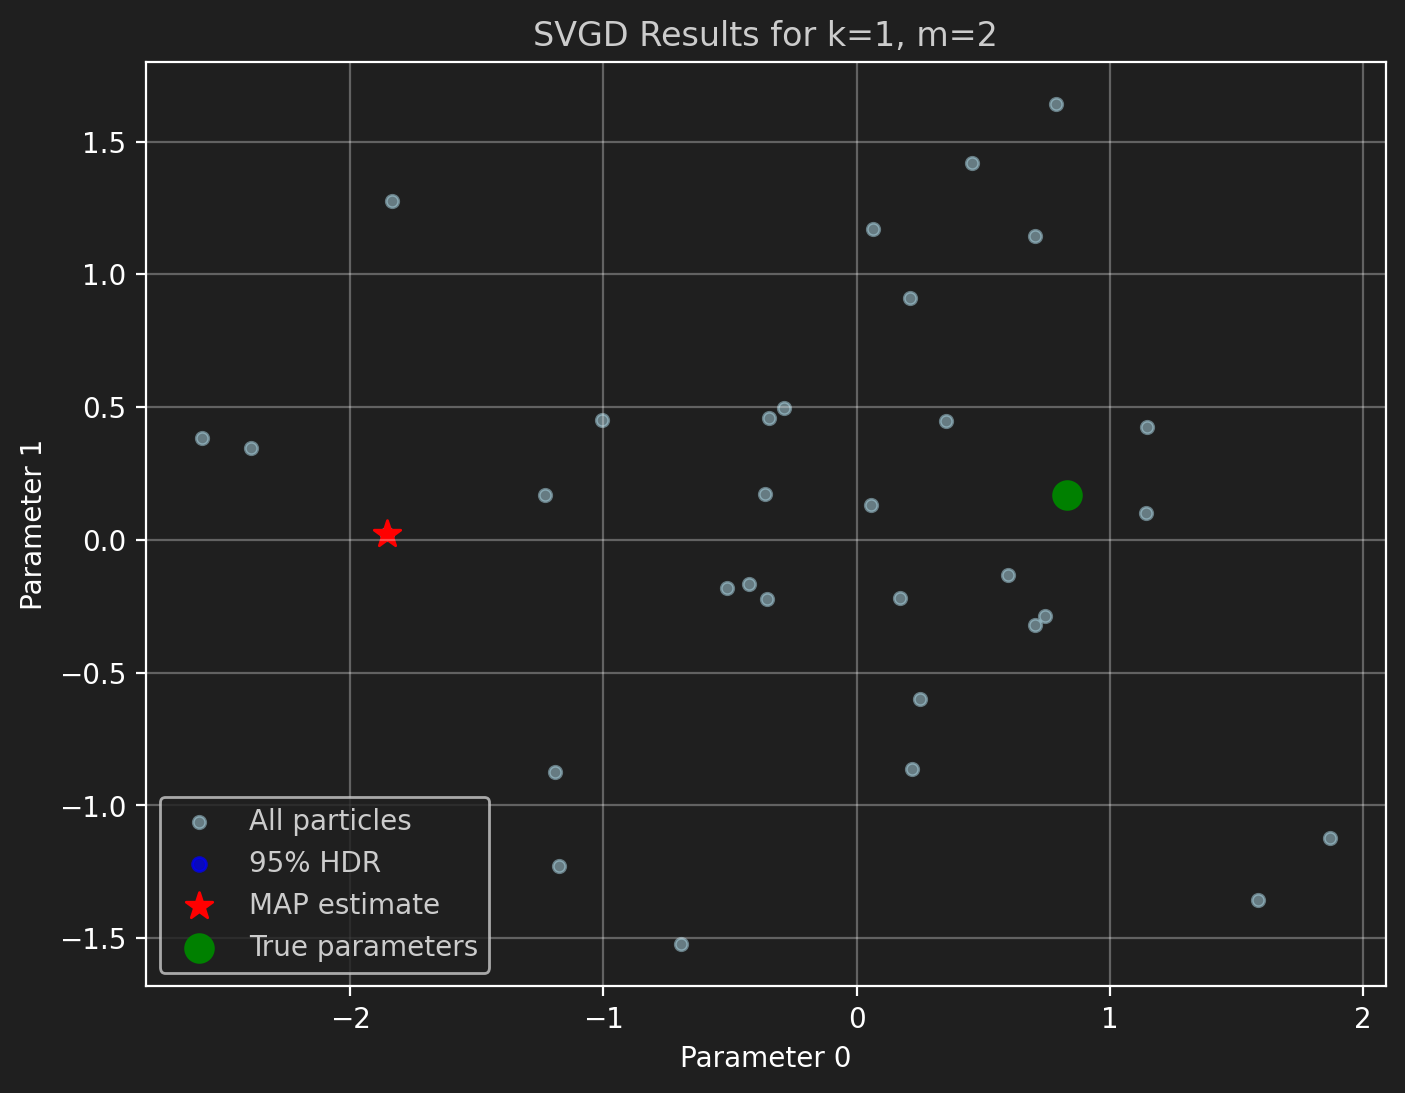


Parameter estimation errors: [0.9920773  0.10558157 0.16803212 0.30816397 0.29357588 1.1145663 ]
Mean absolute error: 0.4970


In [9]:
# MAP and HDR analysis for the univariate case
particles_current = particles_1d
data_current = data_1d
k_current = 1
m_current = 2

# Define log probability function for current configuration
def logp_current(theta):
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, theta, k_current, m_current))(data_current))

# Find MAP estimate
def map_estimate_from_particles(particles, logp_fn):
    """Find MAP estimate from particles"""
    log_probs = jnp.array([logp_fn(particles[i]) for i in range(len(particles))])
    best_idx = jnp.argmax(log_probs)
    return particles[best_idx], log_probs[best_idx]

def estimate_hdr(particles, logp_fn, alpha=0.95):
    """Estimate highest density region"""
    log_probs = jnp.array([logp_fn(particles[i]) for i in range(len(particles))])
    sorted_indices = jnp.argsort(-log_probs)
    n_hdr = int(len(particles) * alpha)
    threshold = log_probs[sorted_indices[n_hdr-1]]
    hdr_mask = log_probs >= threshold
    return particles[hdr_mask], threshold

map_point, map_log_prob = map_estimate_from_particles(particles_current, logp_current)
print(f"MAP estimate: {map_point}")
print(f"MAP log probability: {map_log_prob}")

# Get HDR
hdr_particles, threshold = estimate_hdr(particles_current, logp_current, alpha=0.95)
print(f"HDR contains {len(hdr_particles)} particles out of {len(particles_current)}")
print(f"HDR log probability threshold: {threshold}")

# Simple 2D visualization of first two parameters
p_idx = [0, 1]
plt.figure(figsize=(8, 6))

# Plot all particles
plt.scatter(particles_current[:, p_idx[0]], particles_current[:, p_idx[1]], 
           alpha=0.5, s=20, c='lightblue', label='All particles')

# Plot HDR particles
plt.scatter(hdr_particles[:, p_idx[0]], hdr_particles[:, p_idx[1]], 
           alpha=0.7, s=25, c='blue', label='95% HDR')

# Plot MAP estimate
plt.scatter(map_point[p_idx[0]], map_point[p_idx[1]], 
           color='red', s=100, marker='*', label='MAP estimate')

# Plot true parameters
plt.scatter(true_1d[p_idx[0]], true_1d[p_idx[1]], 
           color='green', s=100, marker='o', label='True parameters')

plt.xlabel(f'Parameter {p_idx[0]}')
plt.ylabel(f'Parameter {p_idx[1]}')
plt.title(f'SVGD Results for k={k_current}, m={m_current}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Parameter estimation quality
param_errors = jnp.abs(jnp.mean(particles_current, axis=0) - true_1d)
print(f"\nParameter estimation errors: {param_errors}")
print(f"Mean absolute error: {jnp.mean(param_errors):.4f}")

Testing k=3, m=4 case...
True parameters shape: (28,)
Data shape: (50, 3)
Running SVGD for k=3, m=4 (param_dim=28)
Adjusted n_particles to 48 for even sharding
True parameters shape: (28,)
Data shape: (50, 3)
Running SVGD for k=3, m=4 (param_dim=28)
Adjusted n_particles to 48 for even sharding


100%|██████████| 200/200 [05:29<00:00,  1.65s/it] 




Results for k=3, m=4:
True parameters shape: (28,)
Estimated parameters shape: (48, 28)
Parameter means: [-0.02335208 -0.23921105 -0.09361701 -0.05440266 -0.03694931  0.14939067
 -0.19379821  0.05788049 -0.28950018  0.10534972  0.15028927  0.08694326
  0.12030403  0.07323909  0.0189325   0.12859409  0.04868076  0.10530077
 -0.1322236   0.05258811 -0.07318874  0.14038026 -0.10950091  0.03181225
  0.13675725 -0.18027315 -0.04097453  0.2653326 ]
True parameters: [ 0.02207618  0.54505664  0.29522452  0.1376427  -0.20349288 -1.786989
 -1.2359172  -1.246726   -1.6148093  -0.36958355 -1.5959587  -0.40382552
 -4.129755   -0.7816327  -1.2570137  -0.62723523  0.08255233  1.6901112
  0.89245486  0.21750085  0.96570635  1.1479596   0.60842806  1.0508229
  0.61966723  1.1906471   0.41585675  1.1120019 ]
Final particles shape: (48, 28)


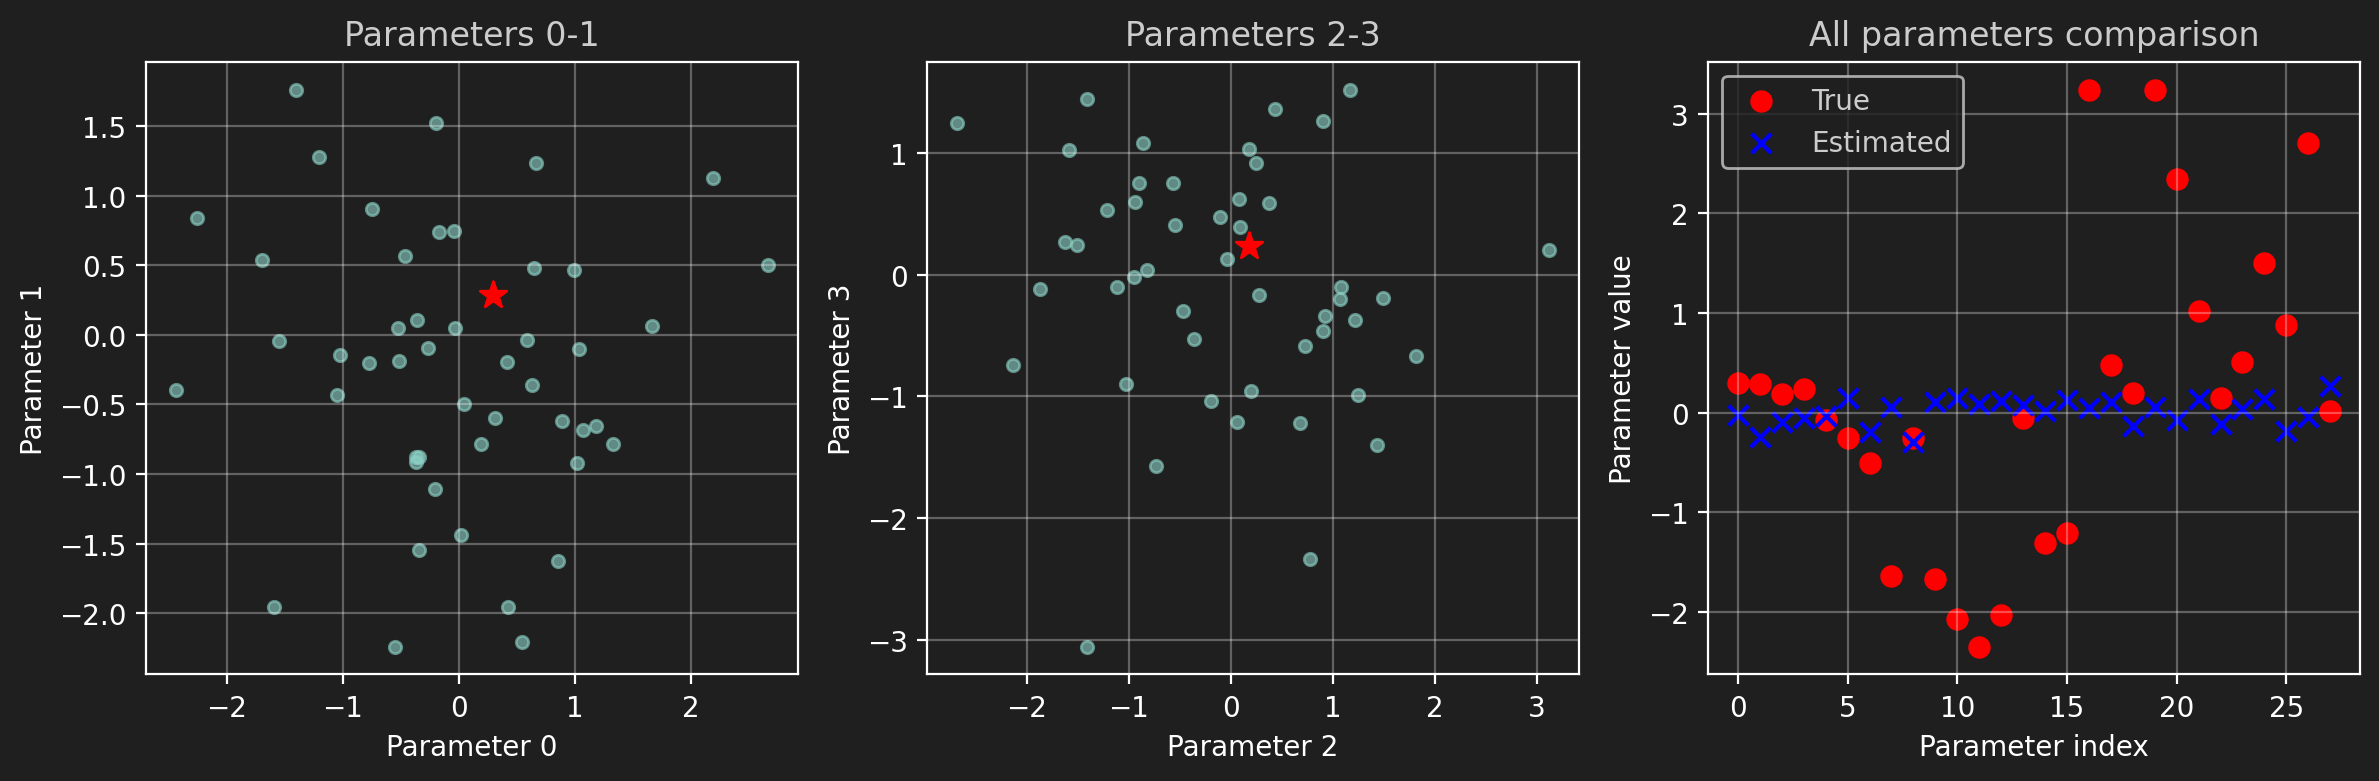

Parameter estimation errors (k=3, m=4): [0.32084888 0.5241529  0.27642673 0.28915438 0.0402772  0.40282887
 0.31352124 1.6985344  0.0367977  1.7696602  2.2245877  2.433013
 2.1519785  0.12644866 1.3276285  1.3336893  3.1860507  0.3748619
 0.32688037 3.1883698  2.4189858  0.8777119  0.25297678 0.47302097
 1.3596188  1.0566751  2.7455413  0.24378572]
Mean absolute error: 1.1348
Max absolute error: 3.1884

Testing k=2, m=6 case...
Running SVGD for k=2, m=6 (param_dim=48)
Adjusted n_particles to 48 for even sharding
Running SVGD for k=2, m=6 (param_dim=48)
Adjusted n_particles to 48 for even sharding


  0%|          | 0/150 [00:00<?, ?it/s]2025-07-17 00:08:40.794595: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_update_median_bw_kl_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-07-17 00:08:40.794595: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_update_median_bw_kl_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-07-17 00:09:19.516502: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2m38.727344s

********************************
[Compiling module jit_update_median_bw_kl_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
**********


Results for k=2, m=6:
True parameters shape: (48,)
Estimated parameters shape: (48, 48)
Parameter means: [-0.13763653  0.19087008 -0.05260308  0.06154226  0.13814549  0.10498359
 -0.09770807  0.02561246  0.26006505 -0.06680728 -0.03323577  0.23735425
 -0.09291991 -0.0200045  -0.00742742  0.13617963 -0.07515632  0.10474753
 -0.07668757  0.04460974  0.10969462 -0.05250935  0.01950194 -0.00268826
  0.04390141  0.01441936 -0.2909751  -0.17075452 -0.16624495  0.00775685
  0.14379895  0.05418278  0.04064218 -0.07655725  0.08303403  0.04381457
  0.14167425 -0.00558831  0.10566442  0.2787858   0.07196832  0.27049524
  0.03883954  0.01835805 -0.16631836 -0.01628136 -0.00723729  0.34894425]
True parameters: [ 0.00937824  0.17671354  0.23974405  0.23695971  0.22164105  0.11556344
 -0.69476426 -4.692371   -1.4038628  -0.85350066 -3.2154138  -0.7128865
 -0.28654706 -0.5446652  -1.315616   -0.10230128 -3.1939766  -4.1186714
 -2.4600773  -0.56841403 -1.8378587  -0.51773375 -2.130164   -0.7539669
 -0

In [10]:
# Test with higher dimensions (k=3, m=4)
print("Testing k=3, m=4 case...")

key, subkey = jax.random.split(key)
true_3d = example_ptd_spec(subkey, k=3, m=4)
n_obs = 50
data_3d = simulate_example_data(subkey, true_3d, k=3, m=4, n_samples=n_obs)

# Run SVGD
print(f"True parameters shape: {true_3d.shape}")
print(f"Data shape: {data_3d.shape}")

# Use a fresh key for SVGD
key, subkey = jax.random.split(key)
particles_3d, history_3d, true_3d_internal = run_variable_dim_svgd(
    subkey, data_3d, k=3, m=4, 
    n_particles=50, n_steps=200, lr=0.001
)

print(f"Final particles shape: {particles_3d.shape}")

# Quick visualization for 3x4 case
plt.figure(figsize=(12, 4))

# Plot first two parameters
plt.subplot(1, 3, 1)
plt.scatter(particles_3d[:, 0], particles_3d[:, 1], alpha=0.6, s=20)
plt.scatter(true_3d[0], true_3d[1], color='red', s=100, marker='*')
plt.xlabel('Parameter 0')
plt.ylabel('Parameter 1')
plt.title('Parameters 0-1')
plt.grid(True, alpha=0.3)

# Plot next two parameters
plt.subplot(1, 3, 2)
plt.scatter(particles_3d[:, 2], particles_3d[:, 3], alpha=0.6, s=20)
plt.scatter(true_3d[2], true_3d[3], color='red', s=100, marker='*')
plt.xlabel('Parameter 2')
plt.ylabel('Parameter 3')
plt.title('Parameters 2-3')
plt.grid(True, alpha=0.3)

# Parameter means vs true values
plt.subplot(1, 3, 3)
param_means = jnp.mean(particles_3d, axis=0)
plt.scatter(range(len(true_3d)), true_3d, color='red', s=50, label='True', marker='o')
plt.scatter(range(len(param_means)), param_means, color='blue', s=50, label='Estimated', marker='x')
plt.xlabel('Parameter index')
plt.ylabel('Parameter value')
plt.title('All parameters comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Parameter estimation quality
param_errors_3d = jnp.abs(param_means - true_3d)
print(f"Parameter estimation errors (k=3, m=4): {param_errors_3d}")
print(f"Mean absolute error: {jnp.mean(param_errors_3d):.4f}")
print(f"Max absolute error: {jnp.max(param_errors_3d):.4f}")

# Test even higher dimensions (k=2, m=6) 
print("\nTesting k=2, m=6 case...")

key, subkey = jax.random.split(key)
true_2x6 = example_ptd_spec(subkey, k=2, m=6)
data_2x6 = simulate_example_data(subkey, true_2x6, k=2, m=6, n_samples=75)

key, subkey = jax.random.split(key)
particles_2x6, history_2x6, true_2x6_internal = run_variable_dim_svgd(
    subkey, data_2x6, k=2, m=6,
    n_particles=50, n_steps=150, lr=0.001
)

param_means_2x6 = jnp.mean(particles_2x6, axis=0)
param_errors_2x6 = jnp.abs(param_means_2x6 - true_2x6)
print(f"Parameter estimation errors (k=2, m=6): {param_errors_2x6}")
print(f"Mean absolute error: {jnp.mean(param_errors_2x6):.4f}")
print(f"Max absolute error: {jnp.max(param_errors_2x6):.4f}")

print("\nAll variable dimension tests completed successfully!")

In [15]:
particles_2x6.shape

(48, 48)

Creating parameter matrix plot for k=2, m=6 case...


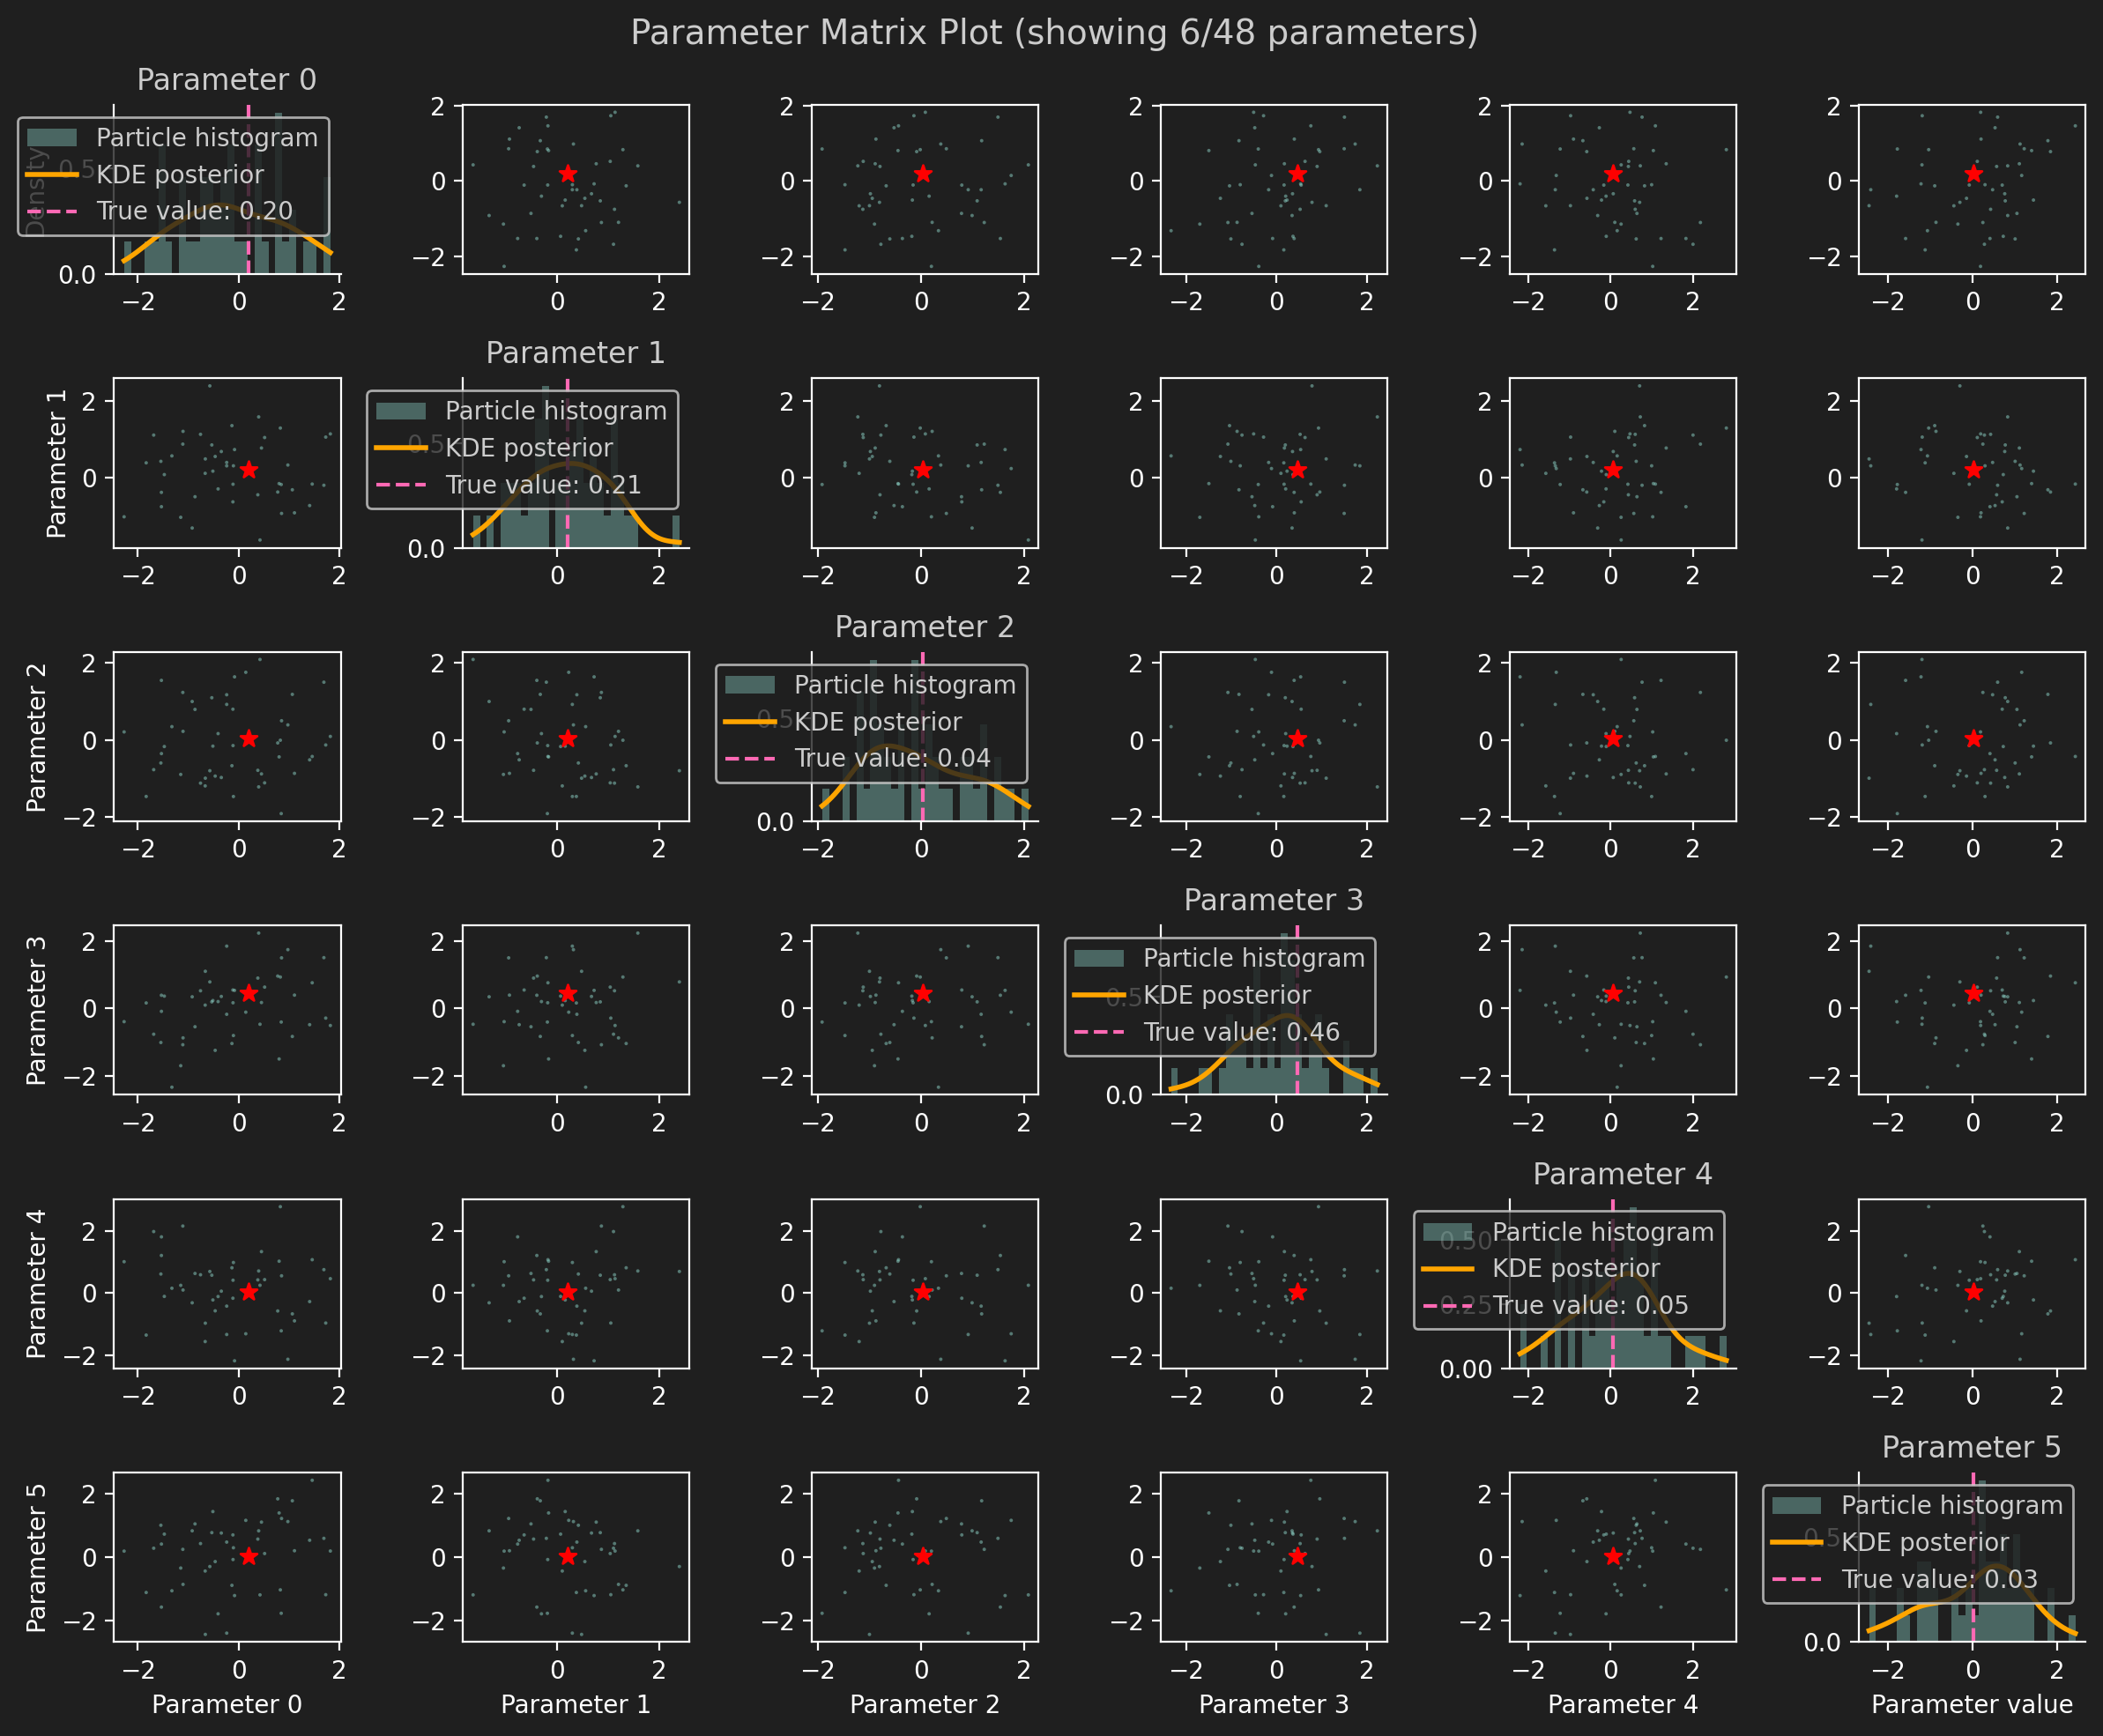


Creating 2D posterior plots for different parameter pairs...
Plotting parameters 0 vs 1 from 48-dimensional space
True parameter values: [ 0.20309676  0.21213232  0.04074225  0.4645696   0.05227577  0.02718337
 -0.03781954 -0.5982956  -0.01487318 -0.464882   -2.1021059  -1.7176101
 -1.2697841  -0.09741129 -1.6097125  -0.5331503  -0.0187189  -1.8386544
 -1.5513748  -2.833916   -1.02902    -0.14403632 -2.9394114  -0.92363507
 -0.6119089  -1.8520703  -1.8769131  -1.817764   -0.02789492 -1.2132554
 -0.8516431  -0.8582751  -0.80583423 -0.17595088 -1.2624929  -0.5416777
  0.17218792  1.2843523   0.21544912  0.05341239  1.8075223   0.04957159
  1.2834888   0.02138453  0.07034606  0.24641035  1.1502812   0.15965568]


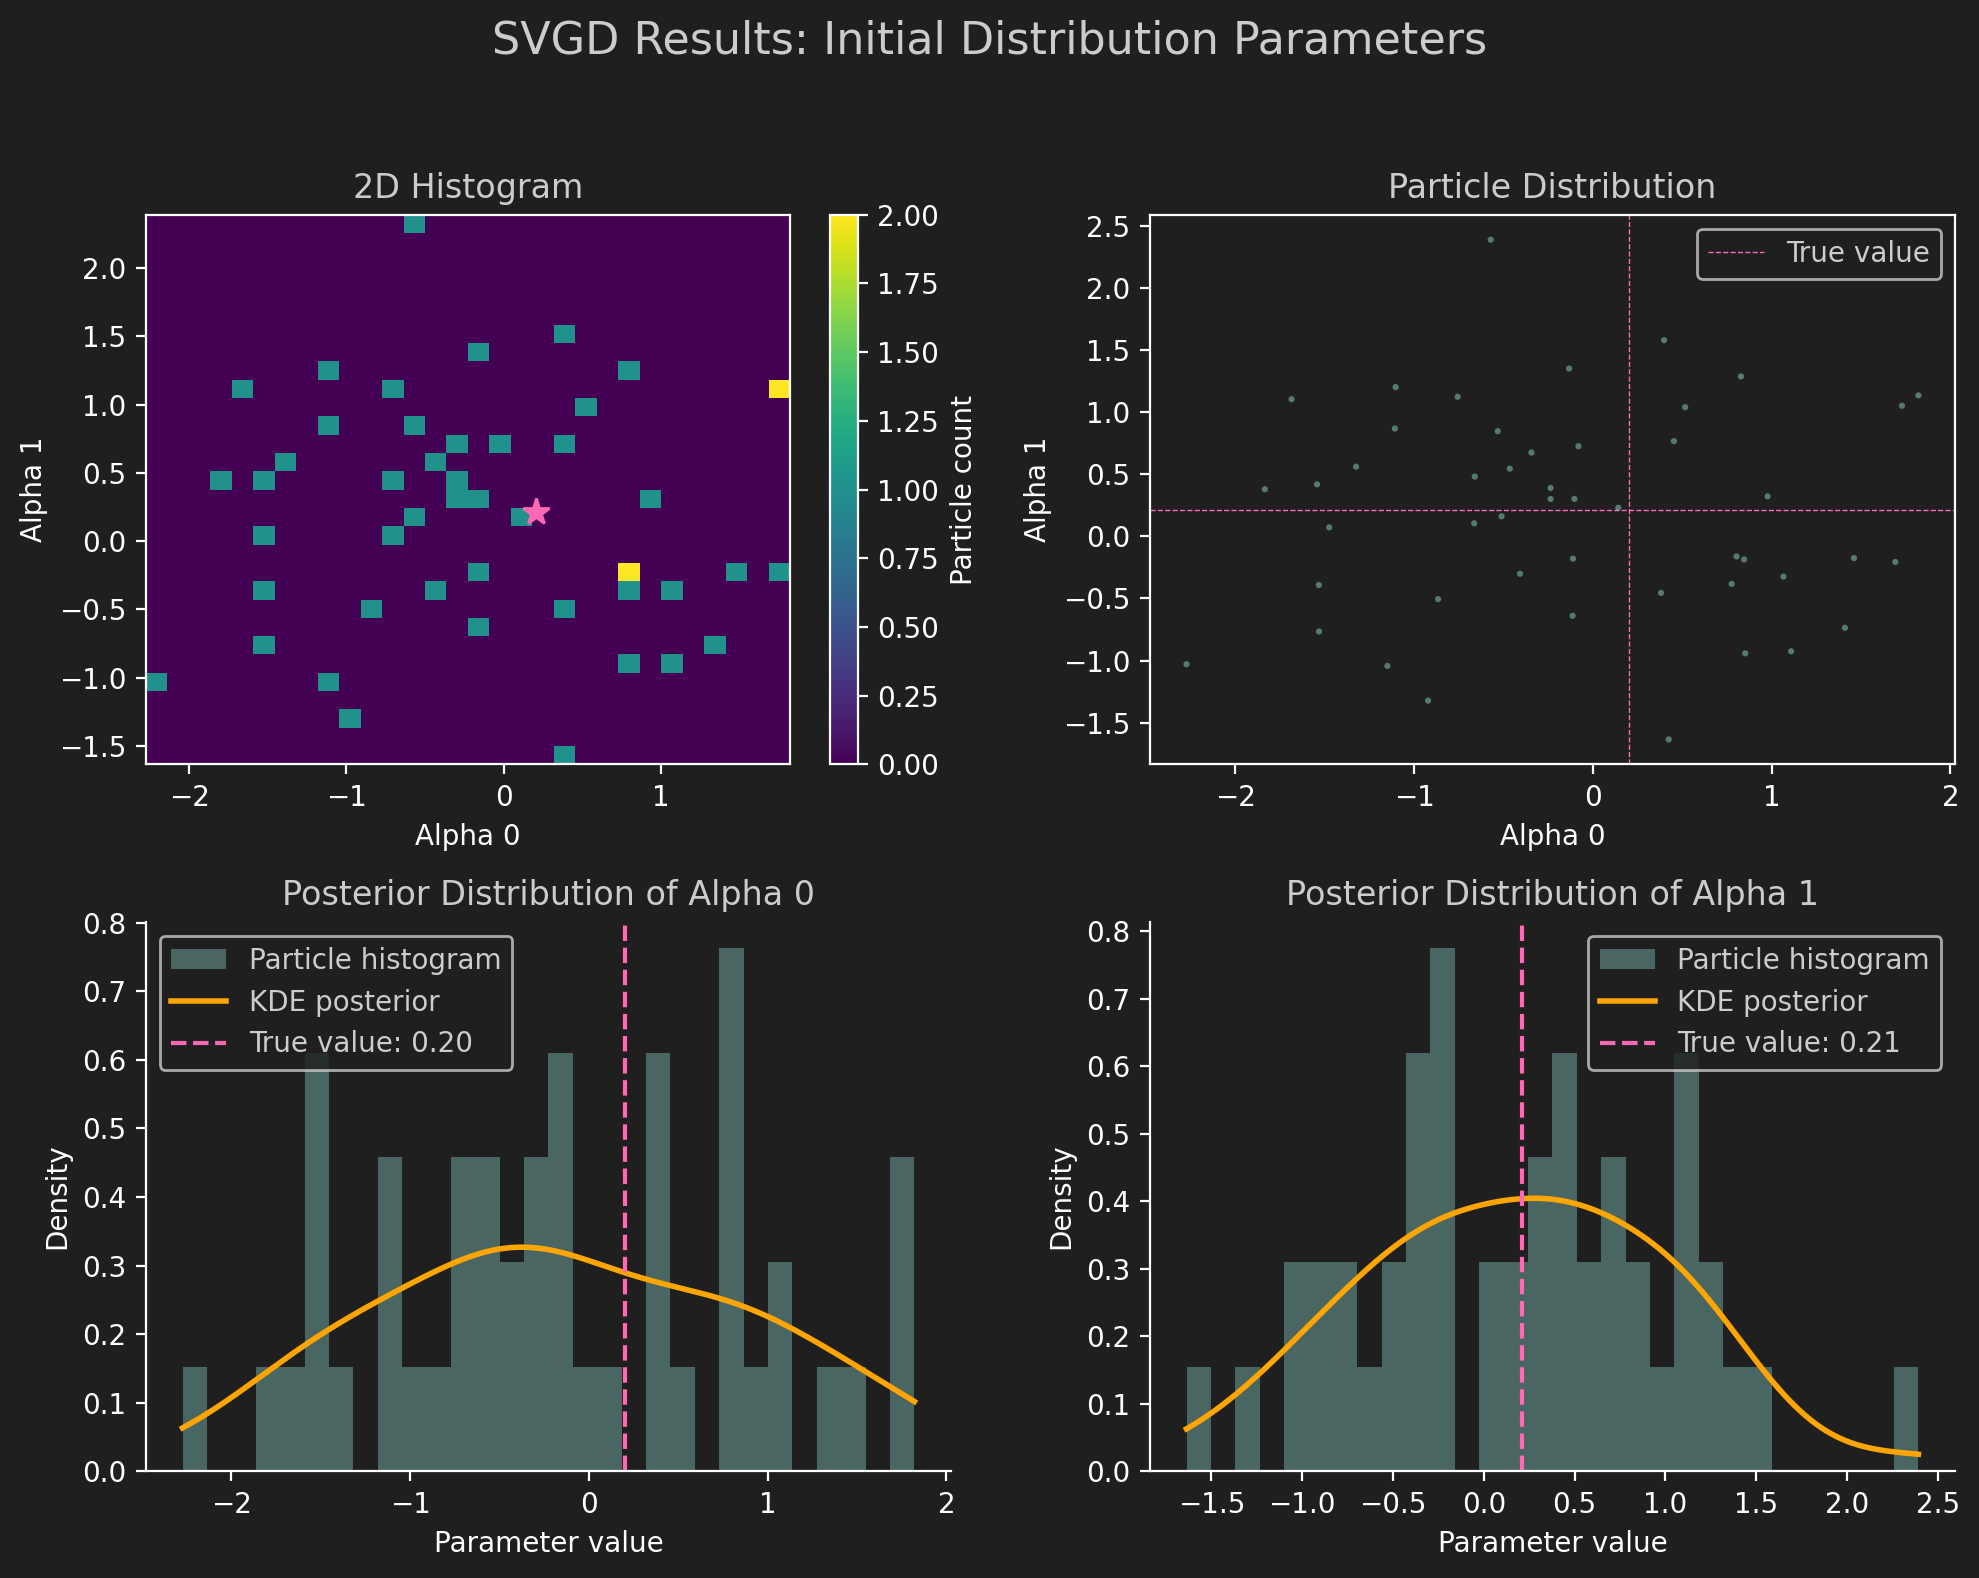

Plotting parameters 4 vs 5 from 48-dimensional space
True parameter values: [ 0.20309676  0.21213232  0.04074225  0.4645696   0.05227577  0.02718337
 -0.03781954 -0.5982956  -0.01487318 -0.464882   -2.1021059  -1.7176101
 -1.2697841  -0.09741129 -1.6097125  -0.5331503  -0.0187189  -1.8386544
 -1.5513748  -2.833916   -1.02902    -0.14403632 -2.9394114  -0.92363507
 -0.6119089  -1.8520703  -1.8769131  -1.817764   -0.02789492 -1.2132554
 -0.8516431  -0.8582751  -0.80583423 -0.17595088 -1.2624929  -0.5416777
  0.17218792  1.2843523   0.21544912  0.05341239  1.8075223   0.04957159
  1.2834888   0.02138453  0.07034606  0.24641035  1.1502812   0.15965568]


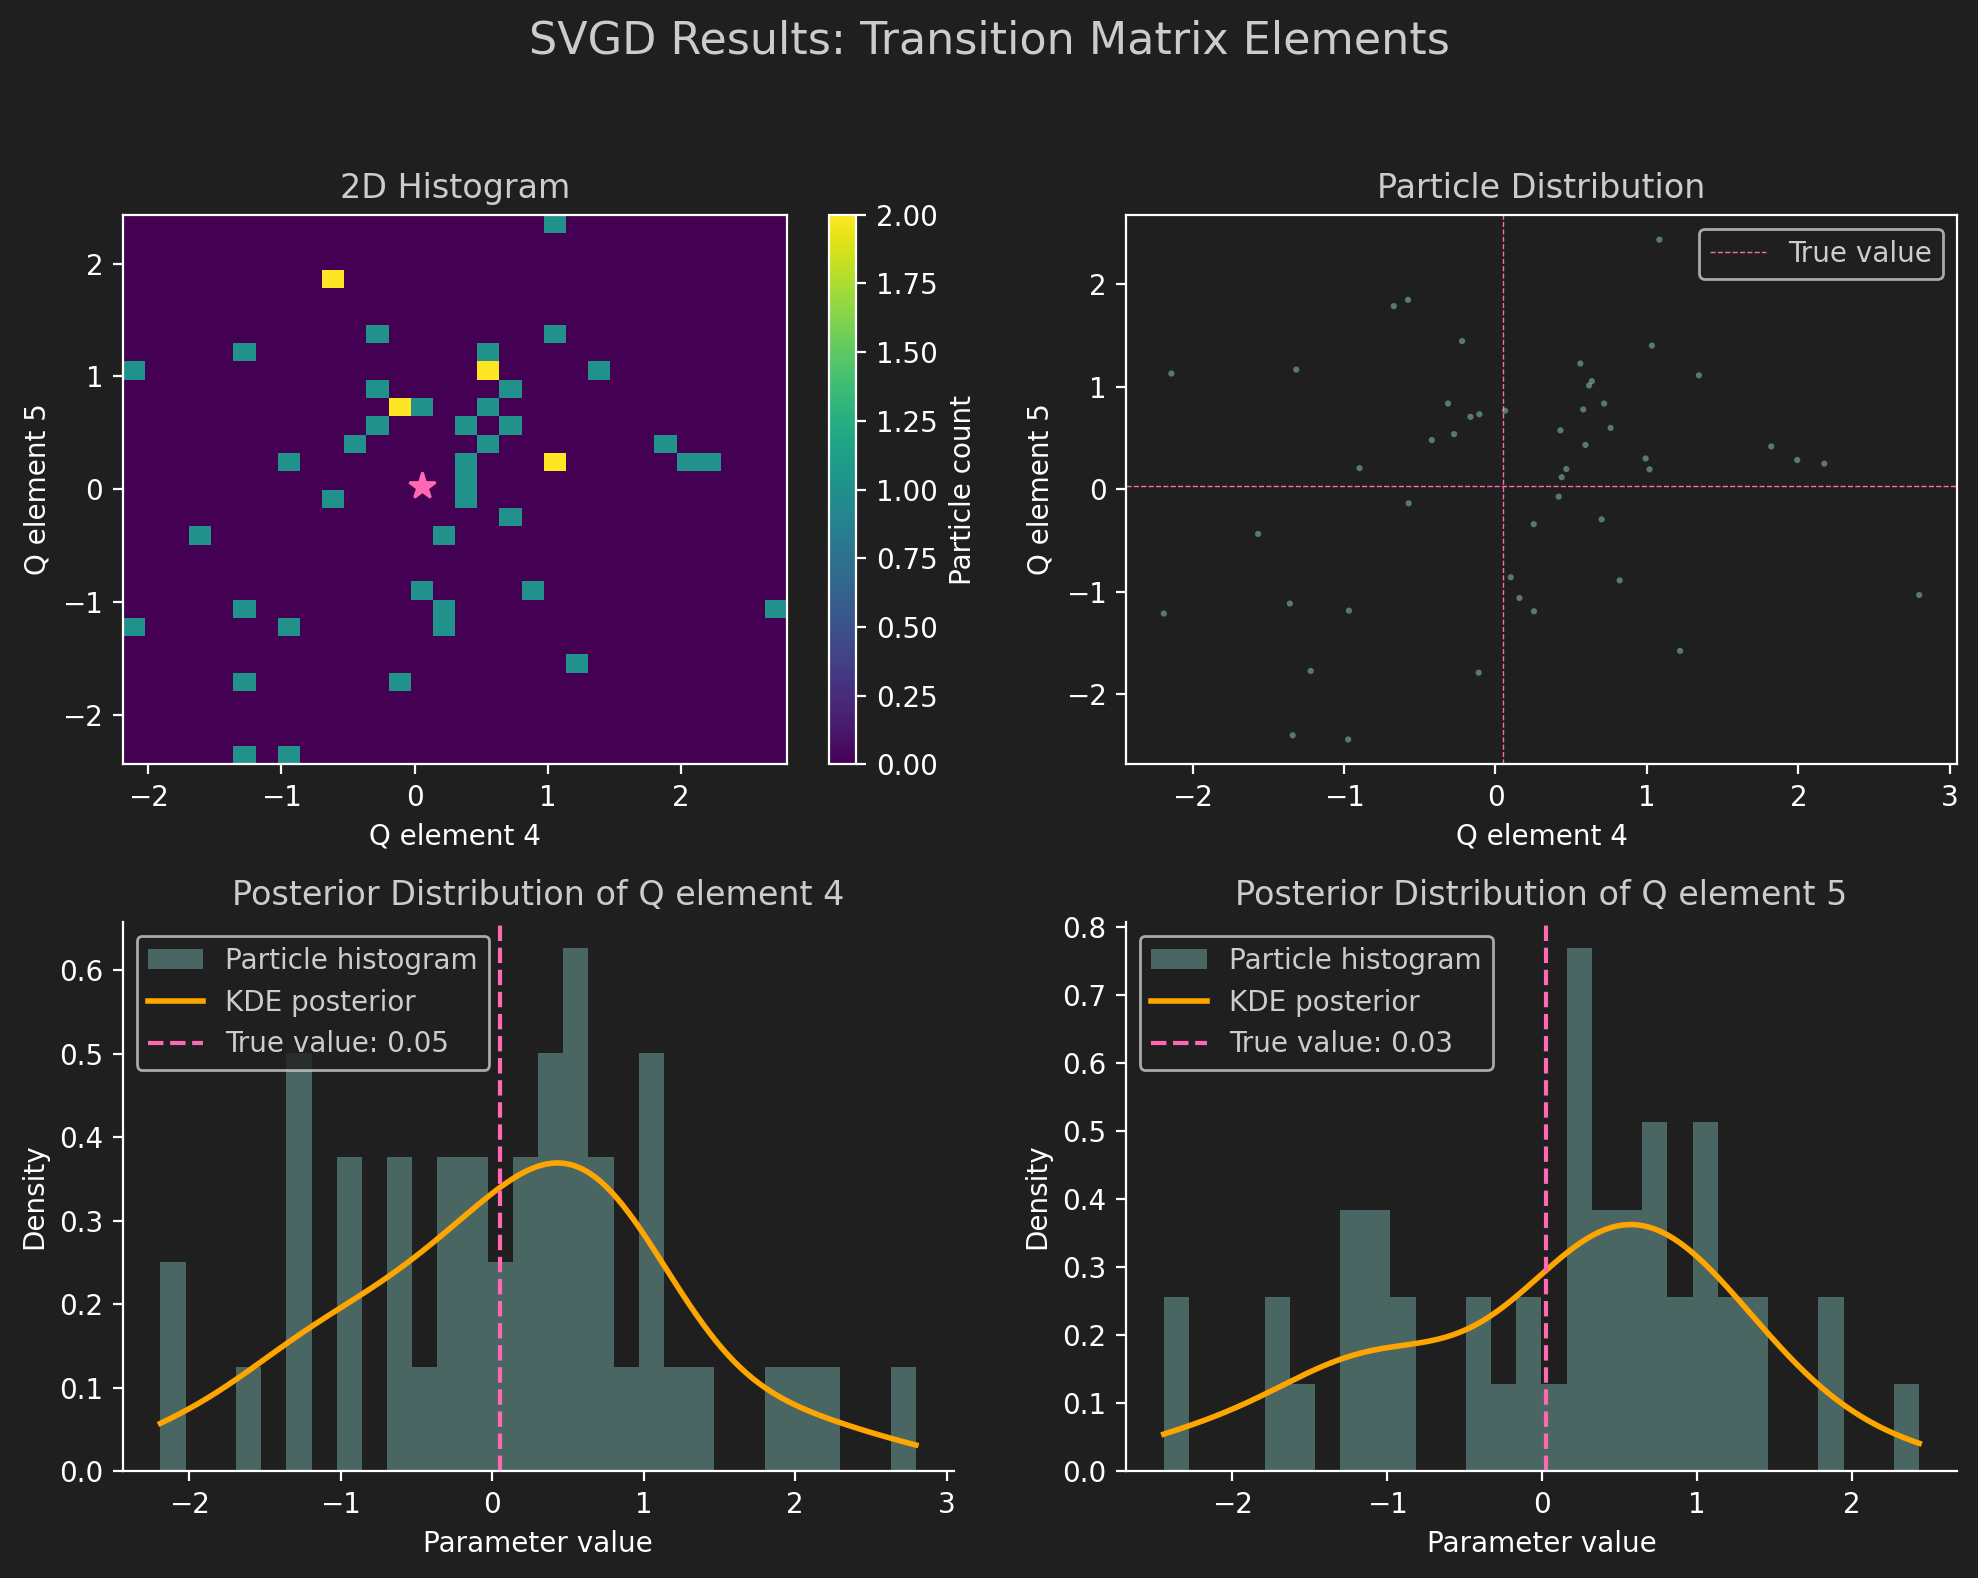

Plotting parameters -2 vs -1 from 48-dimensional space
True parameter values: [ 0.20309676  0.21213232  0.04074225  0.4645696   0.05227577  0.02718337
 -0.03781954 -0.5982956  -0.01487318 -0.464882   -2.1021059  -1.7176101
 -1.2697841  -0.09741129 -1.6097125  -0.5331503  -0.0187189  -1.8386544
 -1.5513748  -2.833916   -1.02902    -0.14403632 -2.9394114  -0.92363507
 -0.6119089  -1.8520703  -1.8769131  -1.817764   -0.02789492 -1.2132554
 -0.8516431  -0.8582751  -0.80583423 -0.17595088 -1.2624929  -0.5416777
  0.17218792  1.2843523   0.21544912  0.05341239  1.8075223   0.04957159
  1.2834888   0.02138453  0.07034606  0.24641035  1.1502812   0.15965568]


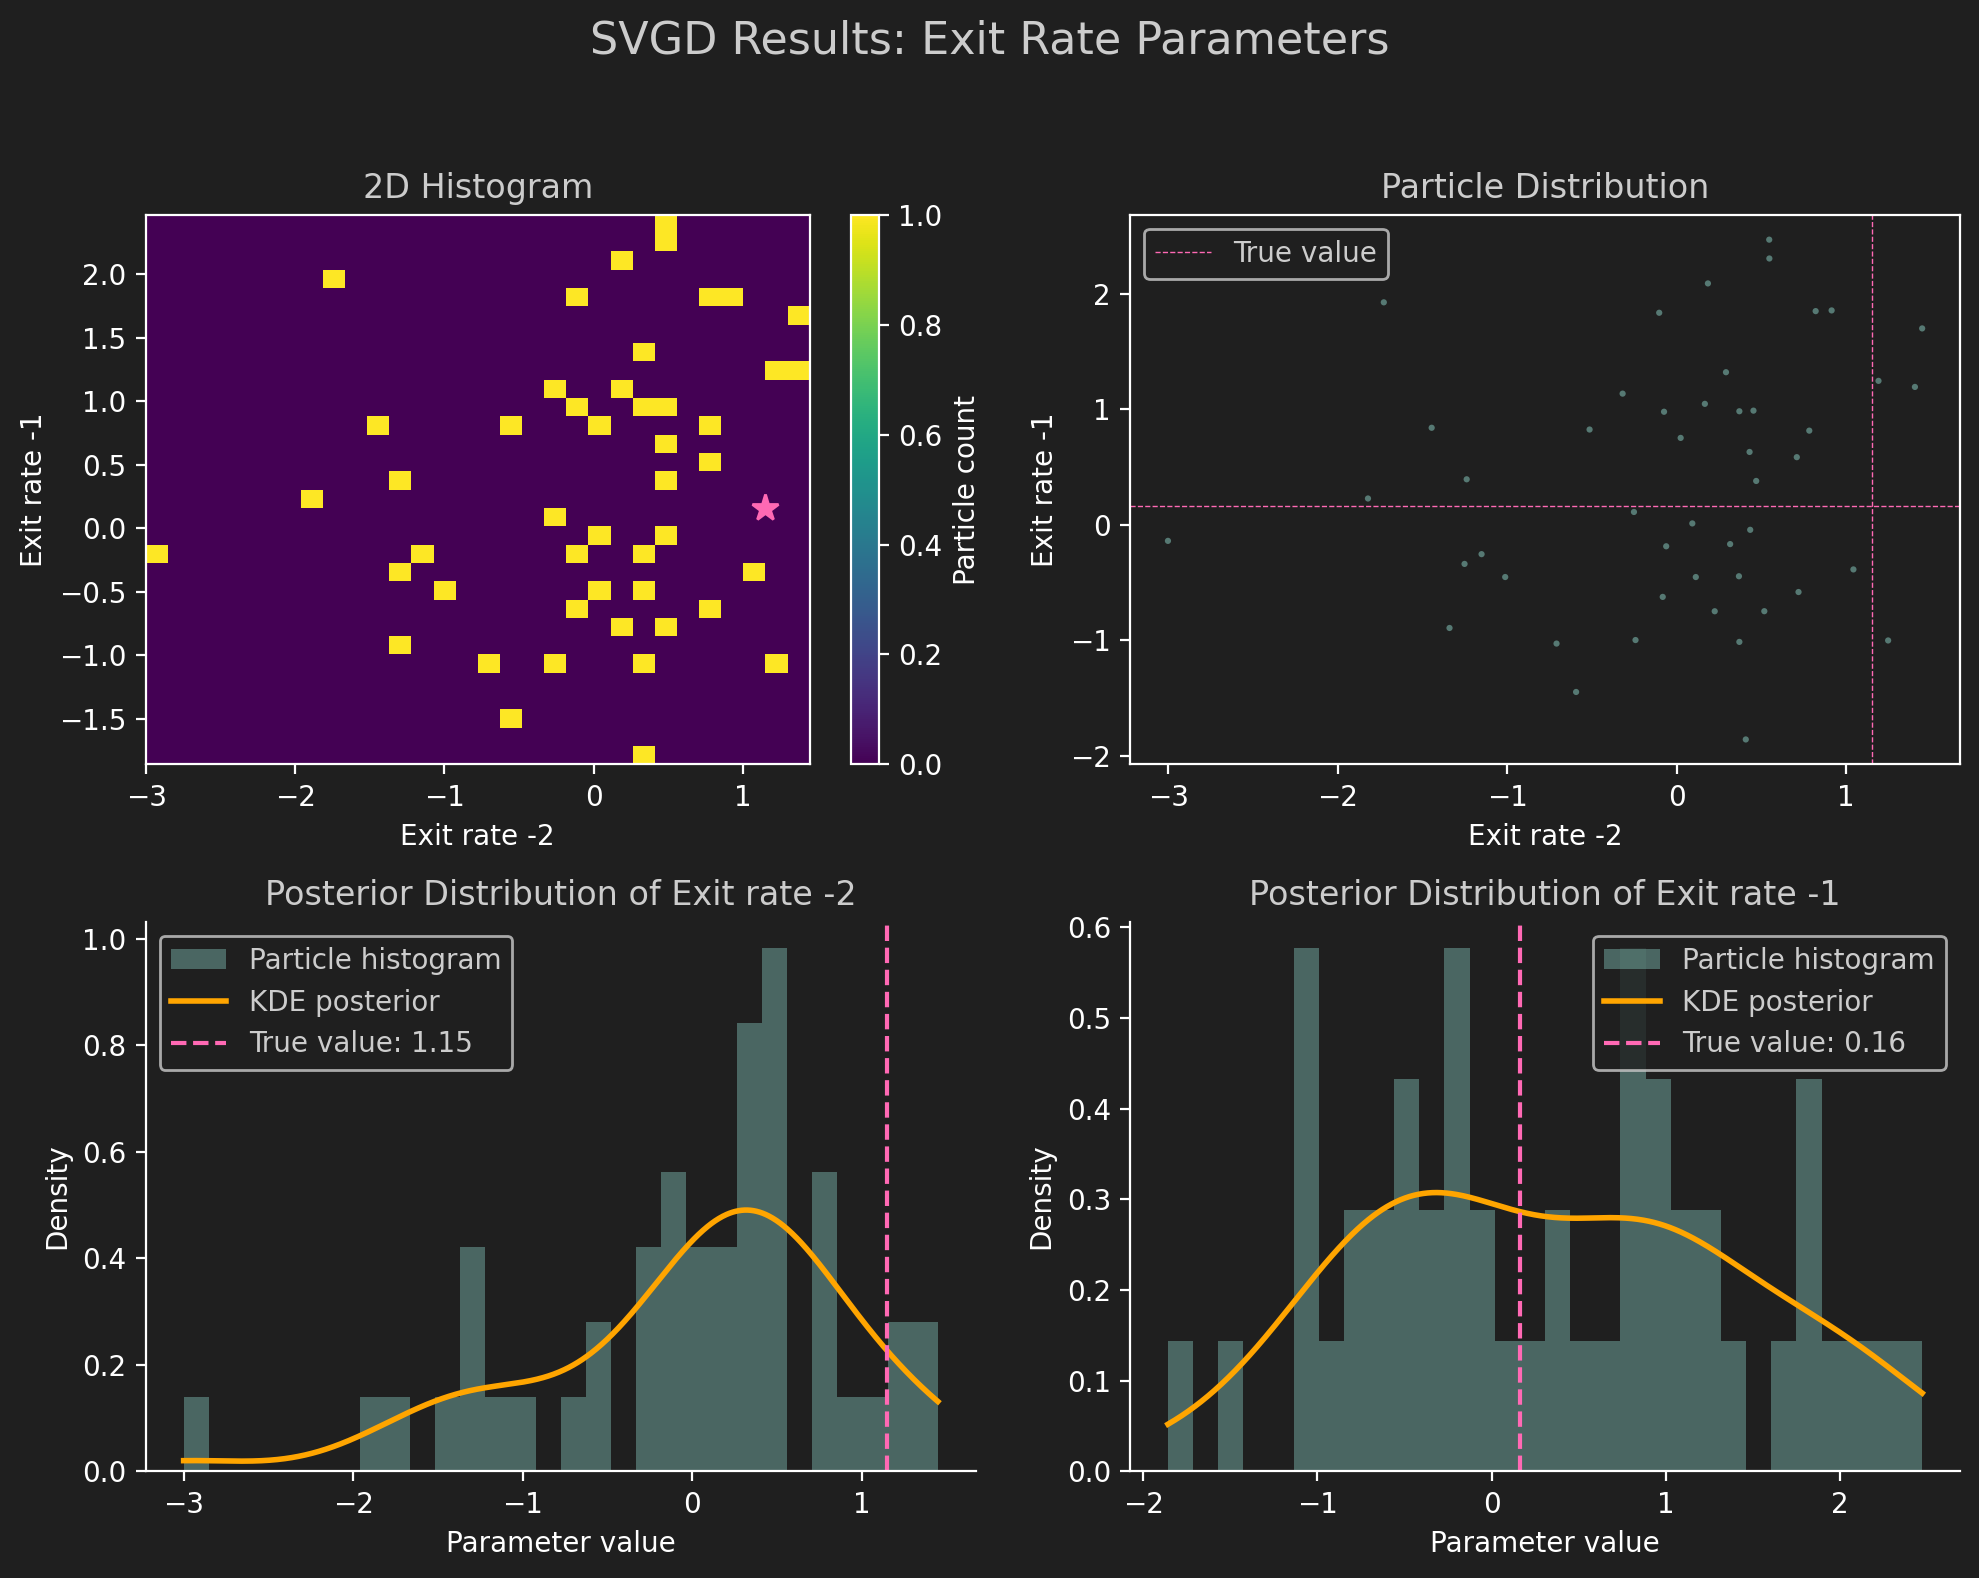


Checking convergence using particle history...


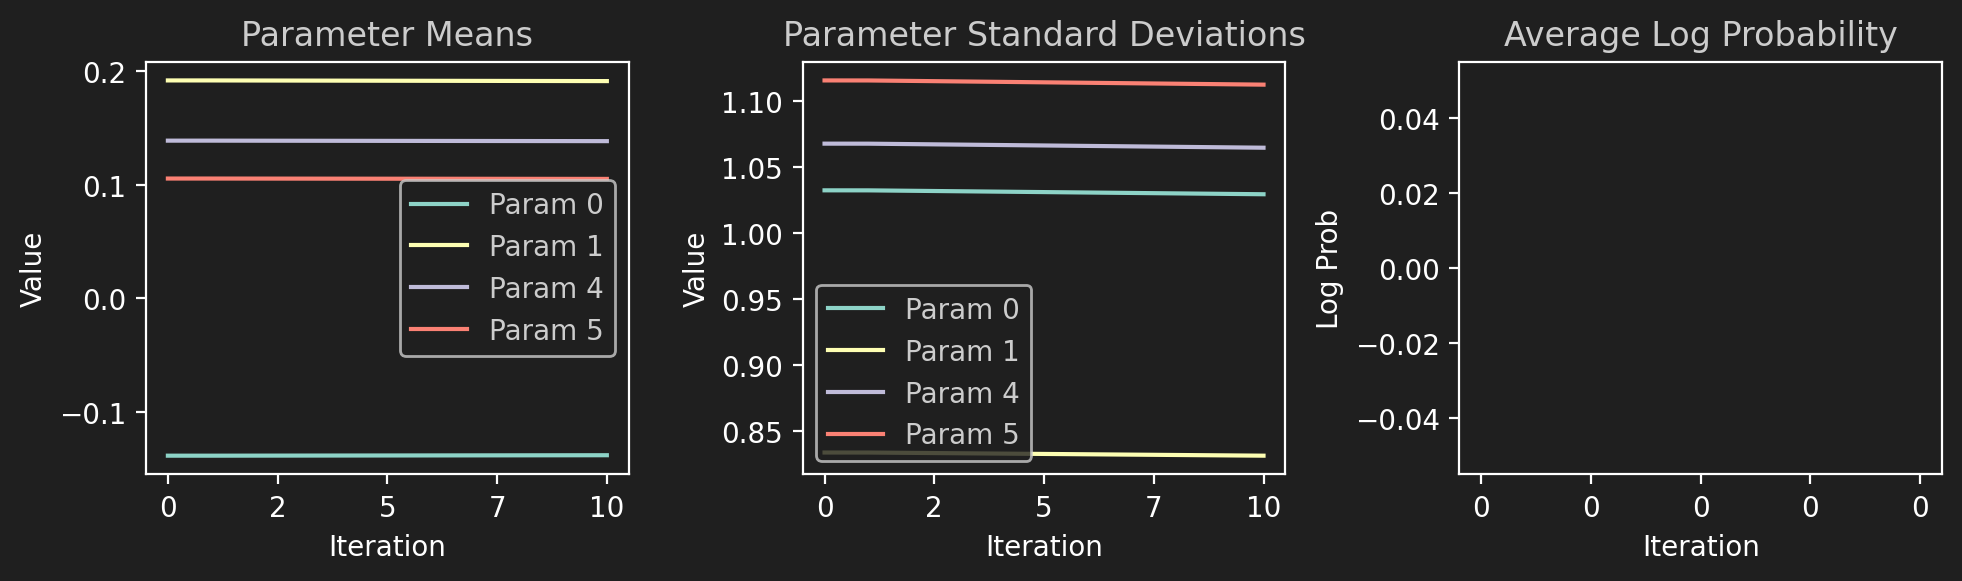


All n-dimensional plotting functions demonstrated successfully!


In [19]:
# Demonstrate the updated plotting functions for n-dimensional data

# 1. Use parameter matrix plot for high-dimensional visualization
print("Creating parameter matrix plot for k=2, m=6 case...")
plot_parameter_matrix(particles_2x6, true_params=true_2x6, max_params=6)
plt.show()

# 2. Create 2D plots for specific parameter pairs
print("\nCreating 2D posterior plots for different parameter pairs...")

# Plot first two parameters
plot_svgd_posterior_2d(particles_2x6, true_params=true_2x6, idx=(0, 1), 
                       labels=["Alpha 0", "Alpha 1"], 
                       title="SVGD Results: Initial Distribution Parameters")
plt.show()

# Plot middle parameters (transition matrix elements)
plot_svgd_posterior_2d(particles_2x6, true_params=true_2x6, idx=(4, 5), 
                       labels=["Q element 4", "Q element 5"], 
                       title="SVGD Results: Transition Matrix Elements")
plt.show()

# Plot last two parameters (exit rates)
plot_svgd_posterior_2d(particles_2x6, true_params=true_2x6, idx=(-2, -1), 
                       labels=["Exit rate -2", "Exit rate -1"], 
                       title="SVGD Results: Exit Rate Parameters")
plt.show()

# 3. Check convergence using particle history (not final particles)
print("\nChecking convergence using particle history...")
# Convert particle history to proper format for convergence checking
history_array = jnp.array([jnp.array([z_to_theta(z) for z in particles_z]) for particles_z in history_2x6])

# Define a simplified log probability function for convergence checking
def log_p_for_convergence(data, params):
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, params, k=2, m=6))(data))

# Check convergence for specific parameters
check_convergence(history_array, log_p_for_convergence, data_2x6, 
                 param_indices=[0, 1, 4, 5], every=1)
plt.show()

print("\nAll n-dimensional plotting functions demonstrated successfully!")

In [ ]:
# Demonstrate animation functions for n-dimensional data

print("Creating animations for SVGD evolution...")

# 1. Single parameter pair animation
print("Animating first two parameters...")
anim1 = animate_svgd_2d(history_array, true_params=true_2x6, idx=[0, 1],
                       labels=["Alpha 0", "Alpha 1"], 
                       title="SVGD Evolution: Initial Distribution")
anim1  # Display animation

# 2. Multiple parameter pairs animation
print("\nAnimating multiple parameter pairs simultaneously...")
param_pairs = [(0, 1), (2, 3), (4, 5)]  # Show 3 different parameter pairs
anim2 = animate_parameter_pairs(history_array, param_pairs=param_pairs, 
                               true_params=true_2x6, figsize=(15, 5))
anim2  # Display animation

print("\nAnimations created successfully!")

In [11]:
#!/bin/bash
#SBATCH --ntasks=10
#SBATCH --cpus-per-task=1
#SBATCH --job-name=jax_dist
#SBATCH --time=01:00:00
#SBATCH --output=out_%j.log

# #SBATCH --nodes=20
# #SBATCH --ntasks-per-node=1
# #SBATCH --cpus-per-task=4

# # Load necessary modules
# module load cuda/12.1
# module load python/3.10  # or activate your env

# coordinator_address must be a globally routable IP or hostname (not 127.0.0.1).
# Make sure NCCL_SOCKET_IFNAME is set to an appropriate network interface
(typically ^lo,docker0 to exclude localhost and docker).
# You can replace srun with mpirun or torchrun if more control is needed, but
SLURM-native srun is preferred for tight integration.
# Avoid hard-coding GPU IDs. jax_local_device_ids="auto" lets JAX select all
local devices

# Define coordinator (rank 0 host and port)
COORDINATOR_HOST=$(scontrol show hostnames $SLURM_JOB_NODELIST | head -n 1)
COORDINATOR_PORT=12345

# Set environment variables
export NCCL_SOCKET_IFNAME=^lo,docker0
export NCCL_DEBUG=INFO

# # Launch one process per GPU using srun
# srun --cpu_bind=none --accel-bind=gn \
#   bash -c 'pixi run python YOUR_JAX_SCRIPT.py slurm \
#     --jax_process_index=$SLURM_PROCID \
#     --jax_process_count=$SLURM_NTASKS \
#     --jax_local_device_ids=auto \
#     --coordinator_address='"$COORDINATOR_HOST:$COORDINATOR_PORT"

pixi run python YOUR_JAX_SCRIPT.py slurm \
    --jax_process_index=$SLURM_PROCID \
    --jax_process_count=$SLURM_NTASKS \
    --jax_local_device_ids=auto \
    --coordinator_address='"$COORDINATOR_HOST:$COORDINATOR_PORT"


SyntaxError: unterminated string literal (detected at line 44) (4240680376.py, line 44)

In [ ]:
import argparse
import jax.distributed

def main():

    # create the top-level parser
    parser = argparse.ArgumentParser()
    parser.add_argument('--foo', action='store_true', help='foo help')
    subparsers = parser.add_subparsers(help='subcommand help')

    # create the parser for the "slurm" command
    parser_slurm = subparsers.add_parser('slurm', help='a help')
    parser_slurm.add_argument("--jax-process-index", type=int, required=True)
    parser_slurm.add_argument("--jax-process-count", type=int, required=True)
    parser_slurm.add_argument("--jax_local_device_ids", type=str, default="auto")
    parser_slurm.add_argument("--coordinator-address", type=str, required=True)

    # # create the parser for the "b" command
    # parser_b = subparsers.add_parser('b', help='b help')
    # parser_b.add_argument('--baz', choices=('X', 'Y', 'Z'), help='baz help')

    args = parser.parse_args()

    if args.coordinator_address:
        # script is envoked with on slurm using the batch script above
        jax.distributed.initialize(
            coordinator_address=args.coordinator_address,
            num_processes=args.jax_process_count,
            process_id=args.jax_process_index,
            local_device_ids=args.jax_local_device_ids,
        )

        # Example distributed computation
        print(f"Running process {jax.process_index()} of {jax.process_count()}")
        print(f"Devices: {jax.local_devices()}")

    run_svgd()

decoder = None
particles = None
particle_history = None

#######################################################
############## FUNCTIONS FROM CELL BELOW ############## 
#######################################################


def run_svgd():

    global decoder, particles, particle_history

    ###################################################
    ############## BODY FROM CELL BELOW ###############
    ###################################################

if __name__ == "__main__":
    main()

In [ ]:
# Demonstrate HDR visualization for n-dimensional data

print("Creating HDR visualizations for different parameter pairs...")

# Define log probability function for HDR
def log_prob_for_hdr(params):
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, params, k=2, m=6))(data_2x6))

# 1. HDR for first two parameters (initial distribution)
print("HDR visualization for initial distribution parameters...")
fig1 = visualize_hdr_2d(particles_2x6, log_prob_for_hdr, idx=[0, 1], 
                       alphas=[0.95, 0.68])  # 95% and 68% HDRs
plt.show()

# 2. HDR for middle parameters (transition matrix)
print("HDR visualization for transition matrix parameters...")
fig2 = visualize_hdr_2d(particles_2x6, log_prob_for_hdr, idx=[4, 5], 
                       alphas=[0.95, 0.68])
plt.show()

# 3. MAP estimation comparison
print("\nMAP estimation results:")
map_particle, map_log_prob = map_estimate_from_particles(particles_2x6, log_prob_for_hdr)
print(f"MAP estimate: {map_particle}")
print(f"MAP log probability: {map_log_prob}")
print(f"True parameters: {true_2x6}")

# Calculate parameter-wise errors
param_errors_map = jnp.abs(map_particle - true_2x6)
print(f"MAP estimation errors: {param_errors_map}")
print(f"Mean absolute MAP error: {jnp.mean(param_errors_map):.4f}")

# Compare with posterior mean
posterior_mean = jnp.mean(particles_2x6, axis=0)
param_errors_mean = jnp.abs(posterior_mean - true_2x6)
print(f"Posterior mean errors: {param_errors_mean}")
print(f"Mean absolute posterior error: {jnp.mean(param_errors_mean):.4f}")

print("\nAll HDR and MAP analyses completed!")